In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.stats import pearsonr
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy import stats
from scipy.signal import convolve,deconvolve
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
import warnings
import matplotlib.cbook
import string
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ 'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'PROGESTERONE'           :'P4'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names = [x[:3] for x in calendar.month_name[1:13]]
letters     = string.ascii_uppercase

In [2]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]

    zf = df.loc[df['age_group'] !='[70,80]'].copy()
    zf = zf.loc[zf['age_group'] !='[60,70)']
#     zf = zf.loc[zf['age_group'] !='[50,60)']
    
    # use ages 20-50 if there are more than 10k mesurements, if there are less, use ages 20-80
    if np.sum(zf['n'].values)>10000:
        df = zf

    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp*2,np.pi,maxamp*2,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        
        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                pars        = pars[winter_peak]
                
        if hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                pars        = pars[winter_peak] 
                
        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))
        all_tests_acrophase  .append(get_acrophase(pars))
        all_tests_relmaxmin  .append(get_relmaxmin(pars))
        
        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    print([aic1,aic2,aic_null])
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

--------------
CORTISOL_BLOOD female


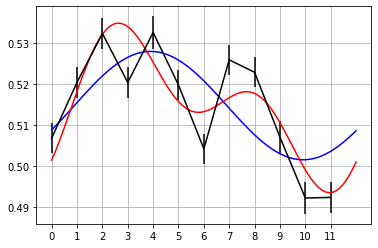

[-106.022963984677, -106.350383644458, -103.465598155168]
2nd order cosinor
acrophase =  3.0438258431824323
maxmin/2 =  0.022198386910238163
--------------
CORTISOL_BLOOD male


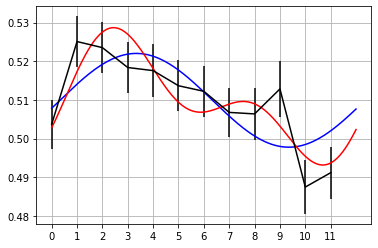

[-111.698569848237, -110.821956067009, -107.922795368418]
1st order cosinor
acrophase =  1.8480945951419643
maxmin/2 =  0.02233088780096305
--------------
CORTISOL_BLOOD both


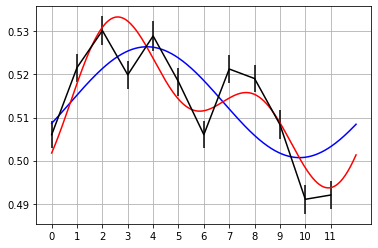

[-108.915444031018, -110.819818429464, -105.403468232294]
2nd order cosinor
acrophase =  2.7576737050446947
maxmin/2 =  0.020959355024936472
--------------
CORTISOL_U_FREE_24h female


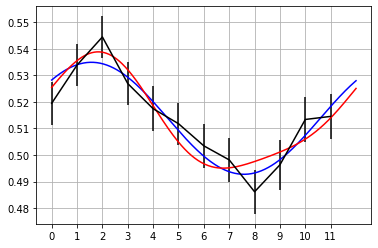

[-120.364147789323, -109.637123548872, -99.5918064853964]
1st order cosinor
acrophase =  1.86755327189935
maxmin/2 =  0.030449638626752977
--------------
CORTISOL_U_FREE_24h male


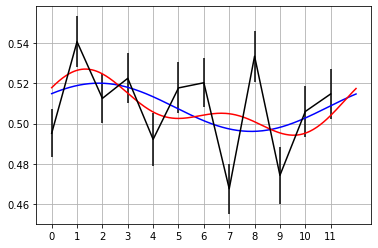

[-88.7576109796184, -80.4767014834044, -92.4818509780920]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
CORTISOL_U_FREE_24h both


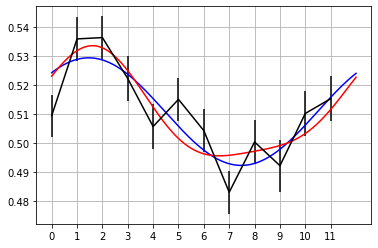

[-110.767079708175, -101.803647650175, -100.620223560988]
1st order cosinor
acrophase =  1.5291412634023291
maxmin/2 =  0.0295805446836267
--------------
T3_FREE female


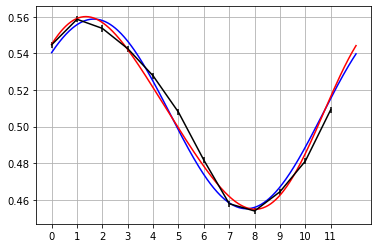

[-119.195841903521, -115.272695309316, -79.2173914191924]
1st order cosinor
acrophase =  1.0249135451533316
maxmin/2 =  0.052340452132058096
--------------
T3_FREE male


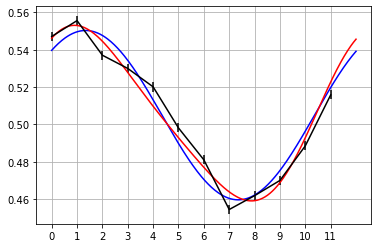

[-113.049509860680, -109.760356178181, -82.0657095682170]
1st order cosinor
acrophase =  0.9980896294376082
maxmin/2 =  0.05051857135622091
--------------
T3_FREE both


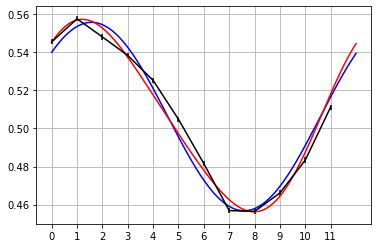

[-117.531135257159, -114.196193297050, -80.2090349991922]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05082824273858219
--------------
T4_FREE female


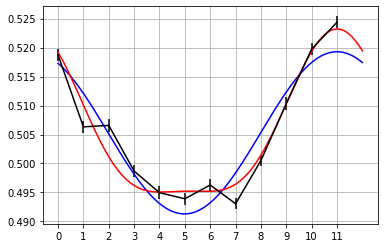

[-130.320795122768, -131.326771226492, -109.419692213649]
2nd order cosinor
acrophase =  10.999999999999998
maxmin/2 =  0.01582152782034142
--------------
T4_FREE male


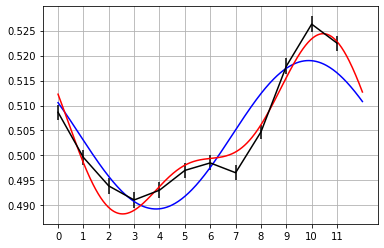

[-122.323316121622, -130.499157084032, -107.106936297908]
2nd order cosinor
acrophase =  10.036468579414034
maxmin/2 =  0.017784265057661508
--------------
T4_FREE both


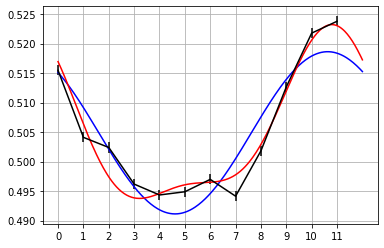

[-128.436926030368, -133.478541218095, -109.601132918153]
2nd order cosinor
acrophase =  10.951941665244721
maxmin/2 =  0.015069066342603563
--------------
ESTRADIOL_E_2 female


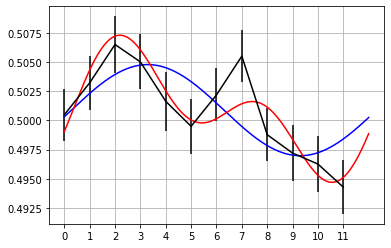

[-136.673548621398, -139.259114014391, -134.481835980605]
2nd order cosinor
acrophase =  2.2871579164373745
maxmin/2 =  0.007309344285371188
--------------
ESTRADIOL_E_2 male


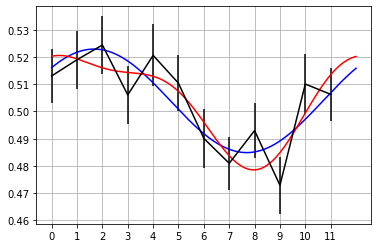

[-108.746824227823, -101.408540854703, -99.9551408258750]
1st order cosinor
acrophase =  2.1501873960609736
maxmin/2 =  0.03132210157369019
--------------
ESTRADIOL_E_2 both


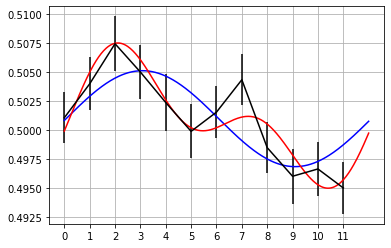

[-139.248882045542, -143.202297998521, -134.229809495686]
2nd order cosinor
acrophase =  2.296003355997306
maxmin/2 =  0.007196237283476544
--------------
TESTOSTERONE_TOTAL female


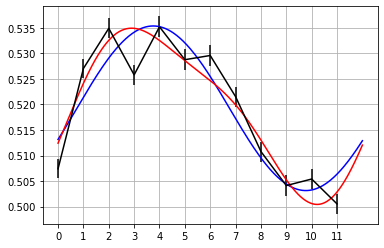

[-123.583455454305, -118.783489854239, -105.708792025883]
1st order cosinor
acrophase =  3.1218691073647102
maxmin/2 =  0.017929847258793534
--------------
TESTOSTERONE_TOTAL male


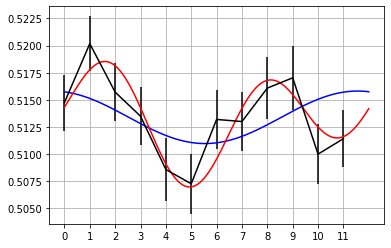

[-132.288352591284, -138.784921274186, -135.445626160671]
2nd order cosinor
acrophase =  1.0615412113476945
maxmin/2 =  0.0076883606527805536
--------------
TESTOSTERONE_TOTAL both


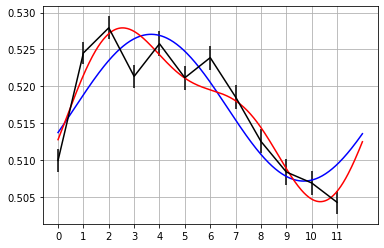

[-129.485778210227, -128.316055804733, -116.260950070121]
1st order cosinor
acrophase =  2.2931088279412624
maxmin/2 =  0.012041180974318019
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female


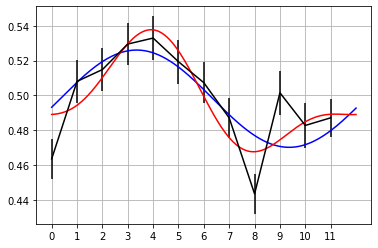

[-93.2411726579052, -88.3393522119729, -88.0971770341953]
1st order cosinor
acrophase =  3.6873108776035193
maxmin/2 =  0.0484588214328234
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male


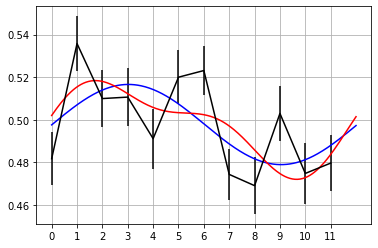

[-92.3250188808167, -84.2073803984422, -92.3538755231639]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both


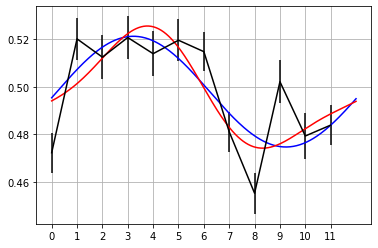

[-96.8753336355983, -88.9881292705296, -92.1025753504068]
1st order cosinor
acrophase =  3.2403018613803036
maxmin/2 =  0.037036573490168936



--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE female


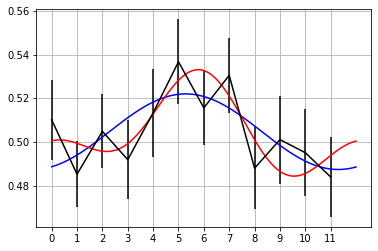

[-100.125725068002, -94.4873229090379, -98.4421512818690]
1st order cosinor
acrophase =  5.592586783726063
maxmin/2 =  0.04065416928091538
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE male


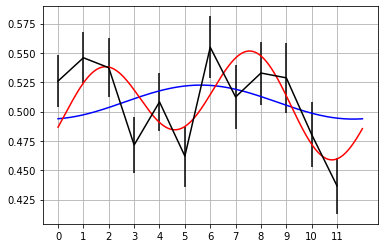

[-74.5152837483509, -72.7121769230165, -80.0876181091522]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE both


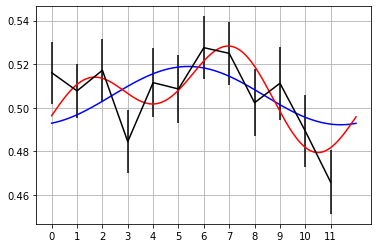

[-95.4509036166033, -91.9256030729444, -97.7402496406848]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TSH_THYROID_STIMULATING_HORMONE female


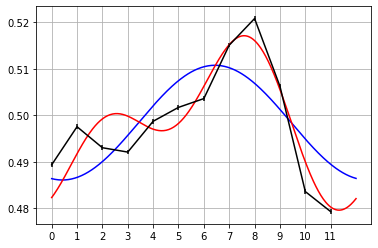

[-111.454752065286, -114.960894634665, -106.991267985709]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.020752673850009996
--------------
TSH_THYROID_STIMULATING_HORMONE male


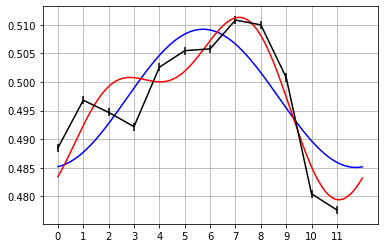

[-117.275300636138, -118.258634063044, -109.530095683043]
2nd order cosinor
acrophase =  7.209541995166993
maxmin/2 =  0.0166367144589803
--------------
TSH_THYROID_STIMULATING_HORMONE both


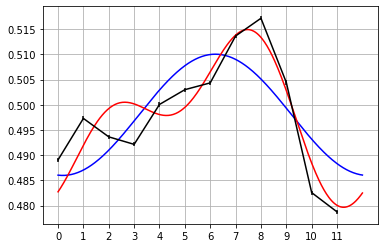

[-113.453618670697, -116.303812900675, -108.132932918213]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.019200010951175645
--------------
LH_LUTEINIZING_HORMONE female


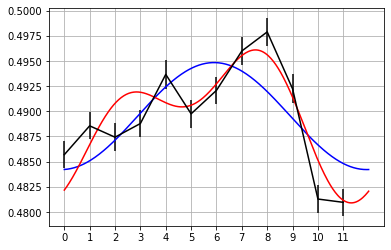

[-131.253549826119, -131.550254948386, -126.973750984338]
2nd order cosinor
acrophase =  7.804537419520457
maxmin/2 =  0.008862309496707587
--------------
LH_LUTEINIZING_HORMONE male


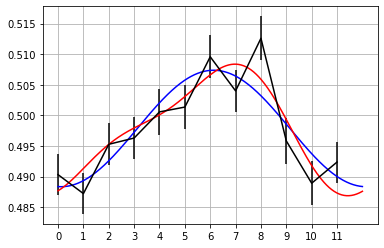

[-128.376296211681, -121.907657588122, -116.907976048184]
1st order cosinor
acrophase =  7.528810298213748
maxmin/2 =  0.013980349345768438
--------------
LH_LUTEINIZING_HORMONE both


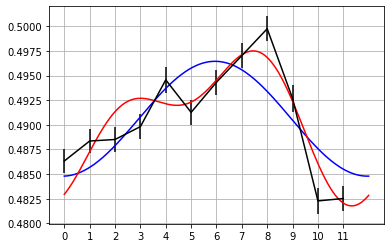

[-132.707665181867, -133.051347301292, -126.296381601918]
2nd order cosinor
acrophase =  7.91759429931512
maxmin/2 =  0.009017886401003327
--------------
FSH_FOLLICLE_STIMULATING_HORMONE female


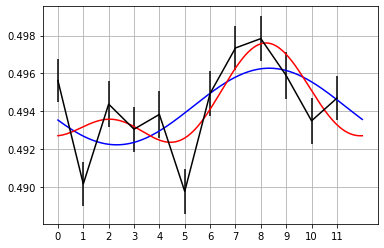

[-145.244871974296, -139.106812411967, -145.261911844608]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
FSH_FOLLICLE_STIMULATING_HORMONE male


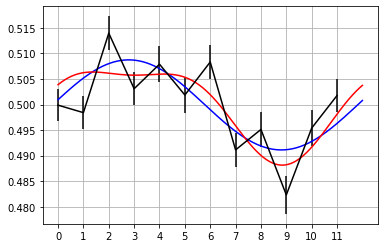

[-120.252778201906, -113.023236937966, -115.666577801222]
1st order cosinor
acrophase =  2.363689883885126
maxmin/2 =  0.016381657306086254
--------------
FSH_FOLLICLE_STIMULATING_HORMONE both


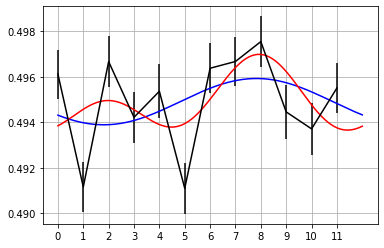

[-144.900854544002, -137.765646499281, -149.131424153216]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH female


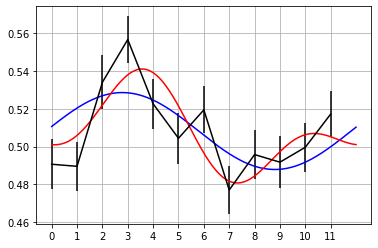

[-93.1259584564794, -88.9257318308831, -92.1356241127114]
1st order cosinor
acrophase =  2.93479309939558
maxmin/2 =  0.04324951569065422
--------------
GROWTH_HORMONE_GH male


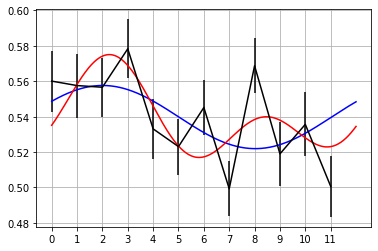

[-86.3144521317912, -80.7518267461433, -88.8639456461617]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH both


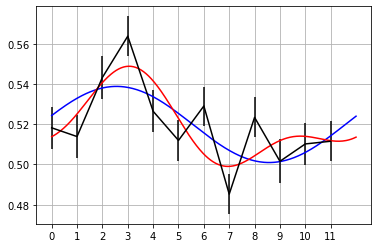

[-96.6271387283598, -90.8957346701185, -94.9042215977621]
1st order cosinor
acrophase =  2.9494634714915295
maxmin/2 =  0.04049992331071645
--------------
PROLACTIN female


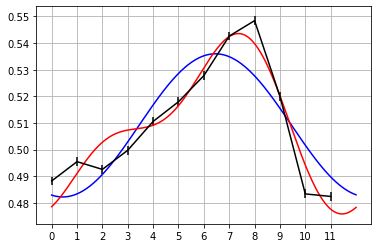

[-104.281504587118, -107.405408937418, -92.0978400738595]
2nd order cosinor
acrophase =  7.994265829866229
maxmin/2 =  0.03329505875747553
--------------
PROLACTIN male


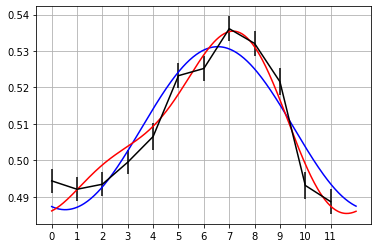

[-117.621676996876, -116.820008903759, -98.0260481025620]
1st order cosinor
acrophase =  7.173744793423119
maxmin/2 =  0.024668666744478575
--------------
PROLACTIN both


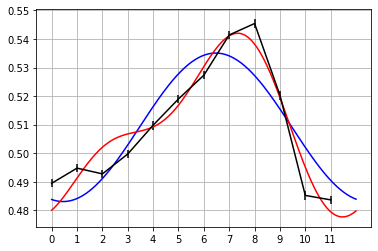

[-106.590861258631, -109.494658701028, -93.2081602301126]
2nd order cosinor
acrophase =  7.977008869828949
maxmin/2 =  0.031049390901989653



--------------
ALDOSTERONE_BLOOD female


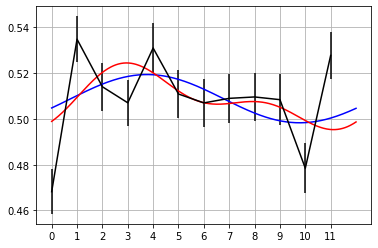

[-92.0885040621116, -83.7844725523869, -95.6634057071109]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD male


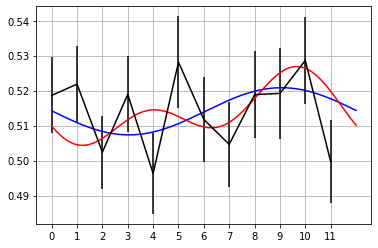

[-104.029065354255, -94.1377932749287, -109.416878781560]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ALDOSTERONE_BLOOD both


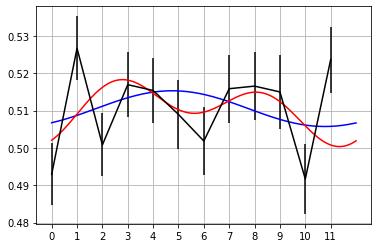

[-102.795940353321, -94.6606070384685, -108.521794672082]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ANDROSTENEDIONE female


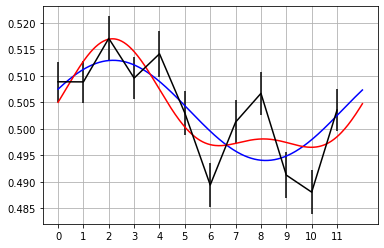

[-116.504294666843, -110.289039953044, -112.748021181397]
1st order cosinor
acrophase =  2.625916102358826
maxmin/2 =  0.016285247052359474
--------------
ANDROSTENEDIONE male


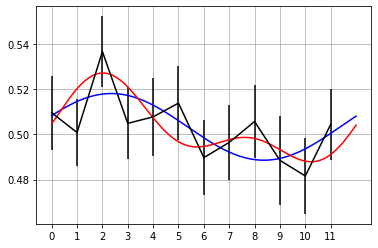

[-104.018212728058, -95.3367109752622, -103.179030493502]
1st order cosinor
acrophase =  2.164603375331186
maxmin/2 =  0.03665478995548633
--------------
ANDROSTENEDIONE both


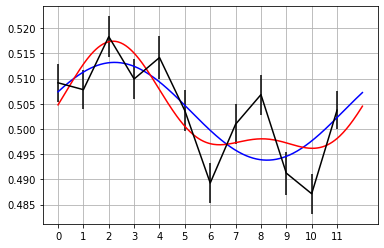

[-115.676920088228, -109.369400703015, -111.979160133411]
1st order cosinor
acrophase =  2.322202759815409
maxmin/2 =  0.016891514863976213
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME female


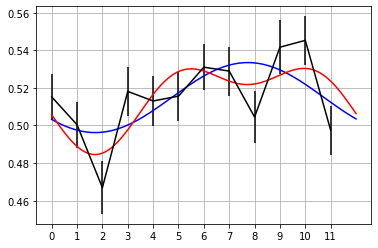

[-93.6046326247935, -87.4996657321277, -93.3152882191962]
1st order cosinor
acrophase =  9.183250746473384
maxmin/2 =  0.04370174719074212
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME male


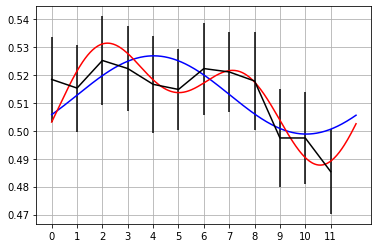

[-109.024236453488, -108.101489986425, -106.289032618377]
1st order cosinor
acrophase =  4.142793447817641
maxmin/2 =  0.03355510495023475
--------------
ANGIOTENSIN_I_CONVERTING_ENZYME both


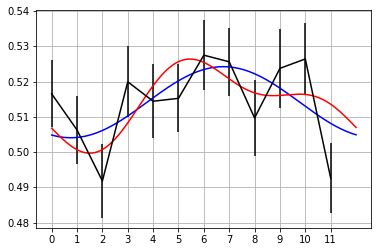

[-106.299126584012, -97.4099618013692, -106.799345111923]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
DHEA_SULPHATE female


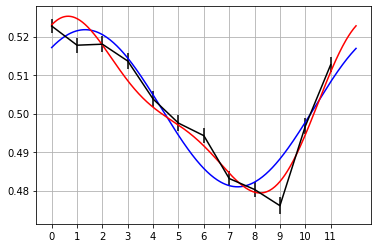

[-121.142230708253, -122.883320169417, -100.386538515527]
2nd order cosinor
acrophase =  0.09753364250277163
maxmin/2 =  0.023457282074016903
--------------
DHEA_SULPHATE male


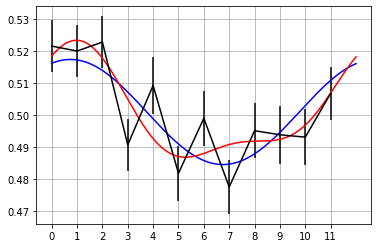

[-107.639415784049, -100.570295531455, -101.532073130224]
1st order cosinor
acrophase =  1.1489938895001568
maxmin/2 =  0.027407093884816495
--------------
DHEA_SULPHATE both


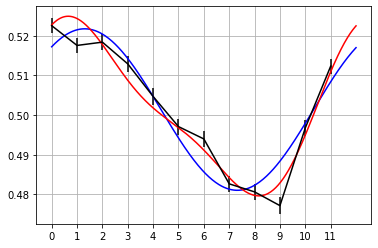

[-122.662904808593, -124.244386377622, -100.697262743224]
2nd order cosinor
acrophase =  0.12724031561832166
maxmin/2 =  0.022896791435546876
--------------
PARATHYROID_HORMONE_PTH female


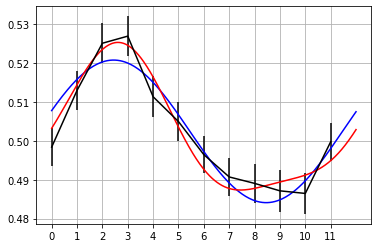

[-125.247593408609, -122.880627512722, -103.410164222116]
1st order cosinor
acrophase =  2.611198274229384
maxmin/2 =  0.023198578581716894
--------------
PARATHYROID_HORMONE_PTH male


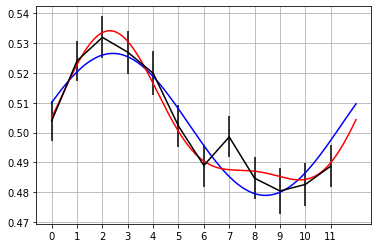

[-116.499214770380, -118.899592329758, -96.6806505709219]
2nd order cosinor
acrophase =  2.185779624372511
maxmin/2 =  0.029634996267978442
--------------
PARATHYROID_HORMONE_PTH both


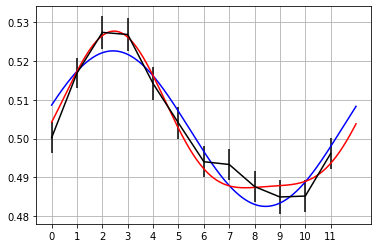

[-125.669221246687, -128.290313592227, -101.250279281189]
2nd order cosinor
acrophase =  2.4209084860536274
maxmin/2 =  0.023707358086803933
--------------
17_HYDROXY_PROGESTERONE female


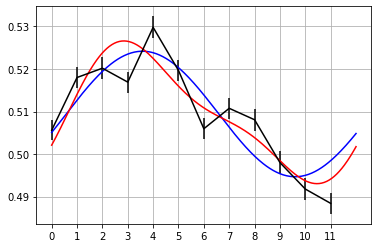

[-118.745944593288, -113.812176011762, -106.504218709925]
1st order cosinor
acrophase =  4.002425979373365
maxmin/2 =  0.02086496425963546
--------------
17_HYDROXY_PROGESTERONE male


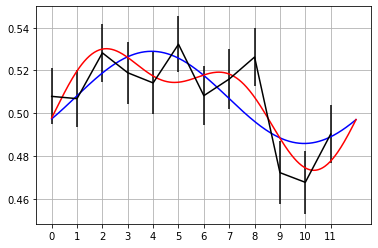

[-97.9068160182640, -93.7253802267126, -93.9776877027978]
1st order cosinor
acrophase =  4.6473093699281245
maxmin/2 =  0.040515593898212895
--------------
17_HYDROXY_PROGESTERONE both


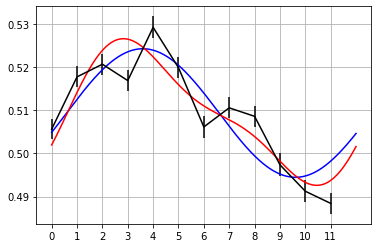

[-118.870905219928, -114.251820336307, -106.371782607973]
1st order cosinor
acrophase =  3.974158806609743
maxmin/2 =  0.020607517761968997
--------------
PROGESTERONE female


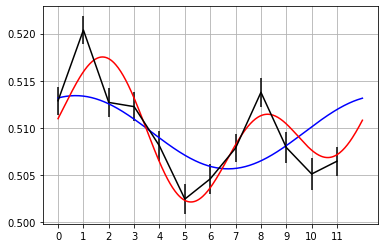

[-127.464649832825, -131.302372703683, -128.227625762965]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.009107458500369625
--------------
PROGESTERONE male


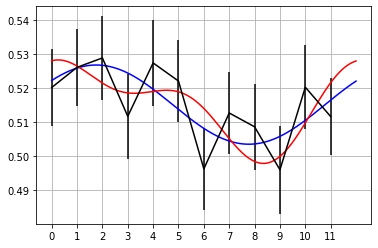

[-110.881822008716, -99.7367029389139, -109.131552138239]
1st order cosinor
acrophase =  2.320442537949984
maxmin/2 =  0.02702225833122796
--------------
PROGESTERONE both


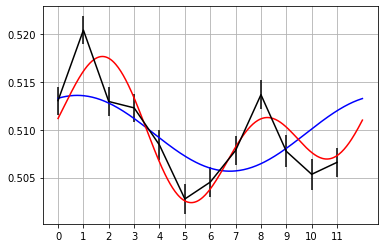

[-128.003566992889, -131.807157847201, -128.390917334127]
2nd order cosinor
acrophase =  0.9980829869341344
maxmin/2 =  0.008932237319825696



--------------
CALCIUM_BLOOD female


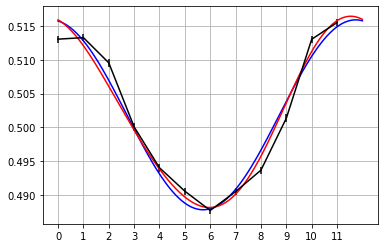

[-145.530373290226, -138.425418081519, -110.406194518403]
1st order cosinor
acrophase =  11.003311281339275
maxmin/2 =  0.013905135003563213
--------------
CALCIUM_BLOOD male


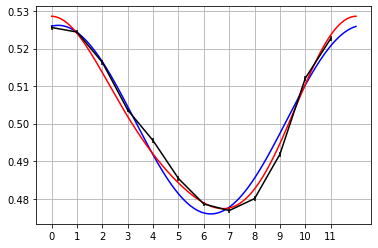

[-133.614093015811, -133.374214644107, -96.4689107788577]
1st order cosinor
acrophase =  0.08302884987342578
maxmin/2 =  0.0244094395829028
--------------
CALCIUM_BLOOD both


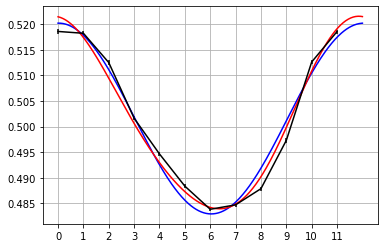

[-141.654827026654, -137.249936666097, -103.662762619272]
1st order cosinor
acrophase =  11.718927390361152
maxmin/2 =  0.017488180018649466
--------------
CREATININE_BLOOD female


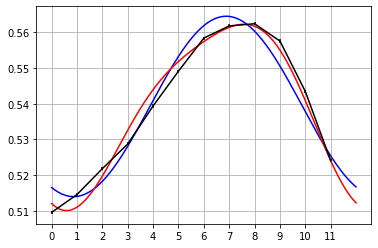

[-126.805465547758, -128.294811936142, -96.0620065557290]
2nd order cosinor
acrophase =  7.834295476665527
maxmin/2 =  0.02646620931165409
--------------
CREATININE_BLOOD male


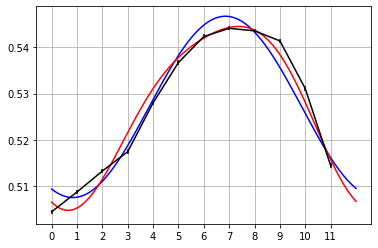

[-133.050083608427, -130.897779291321, -102.288305470768]
1st order cosinor
acrophase =  7.2076559530860695
maxmin/2 =  0.019801530055380035
--------------
CREATININE_BLOOD both


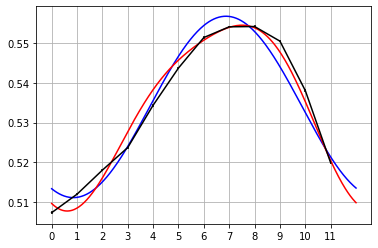

[-129.626920350608, -129.629651185581, -98.5242431294291]
2nd order cosinor
acrophase =  7.553207737173864
maxmin/2 =  0.023523360977897045
--------------
Cl female


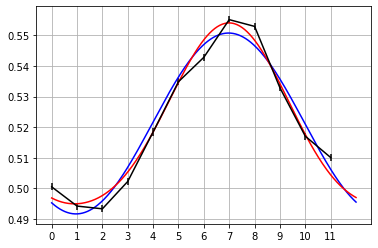

[-126.991927021010, -122.738297483370, -92.4930300571971]
1st order cosinor
acrophase =  7.081078342617138
maxmin/2 =  0.031068224186025107
--------------
Cl male


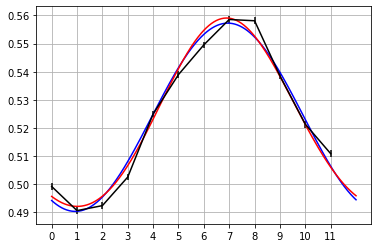

[-129.967787545314, -122.546248174073, -89.7132353885121]
1st order cosinor
acrophase =  7.367160864403662
maxmin/2 =  0.034261803815392226
--------------
Cl both


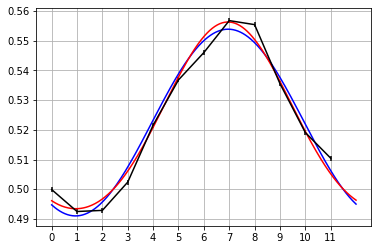

[-128.880832187513, -122.916713040263, -91.1482206264375]
1st order cosinor
acrophase =  7.132069739419089
maxmin/2 =  0.03231420250891918
--------------
GLUCOSE_BLOOD female


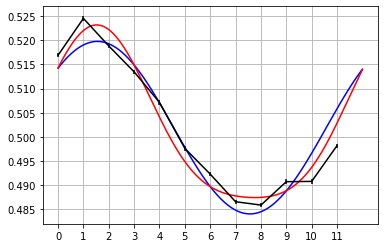

[-129.820749826827, -127.530103780134, -104.129292833206]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.019332157494416385
--------------
GLUCOSE_BLOOD male


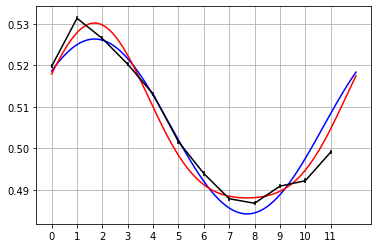

[-127.512575524490, -125.774767368465, -100.217776157408]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02229321368445433
--------------
GLUCOSE_BLOOD both


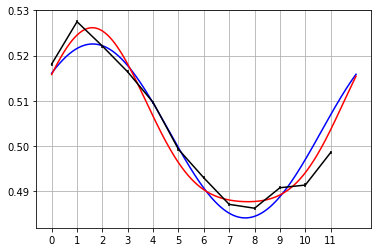

[-128.874908936280, -126.879511172011, -102.367687920103]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.02061577511972814
--------------
HEMOGLOBIN_A1C_CALCULATED female


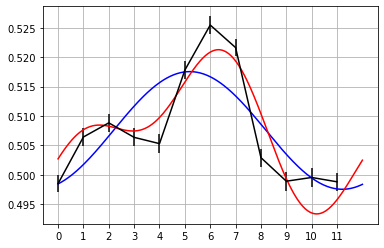

[-119.527878360735, -120.344366945907, -113.284814102355]
2nd order cosinor
acrophase =  6.036468579414033
maxmin/2 =  0.014140653727340987
--------------
HEMOGLOBIN_A1C_CALCULATED male


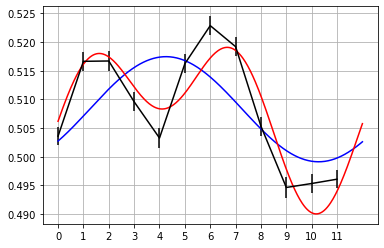

[-113.598586138822, -120.990353908158, -111.635149315744]
2nd order cosinor
acrophase =  6.053368110110914
maxmin/2 =  0.014571427996211216
--------------
HEMOGLOBIN_A1C_CALCULATED both


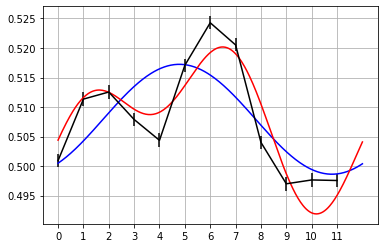

[-117.198753998032, -121.396138488721, -113.289743281087]
2nd order cosinor
acrophase =  6.007647593103244
maxmin/2 =  0.01397870921276375
--------------
HGB female


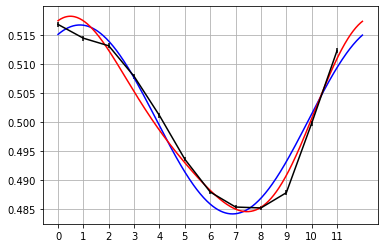

[-139.569084455715, -138.405435790084, -106.654169257846]
1st order cosinor
acrophase =  0.0
maxmin/2 =  0.015938263110370533
--------------
HGB male


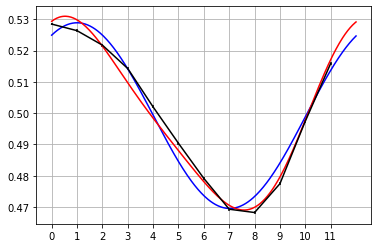

[-127.481543884466, -130.868964232998, -92.4227781612137]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.030114070447929152
--------------
HGB both


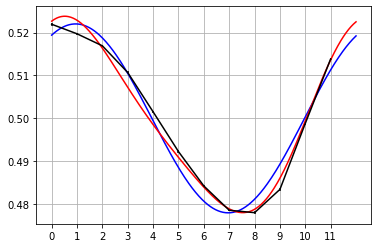

[-134.324110236826, -136.154226896913, -99.5159081860002]
2nd order cosinor
acrophase =  0.0
maxmin/2 =  0.022021242662739467
--------------
MAGNESIUM_BLOOD female


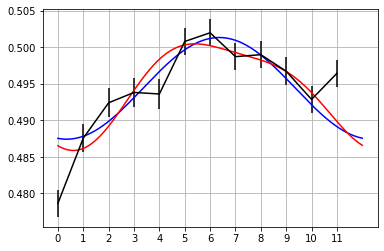

[-129.526620385974, -122.042854862498, -122.334162664343]
1st order cosinor
acrophase =  5.905296376784349
maxmin/2 =  0.011910741710672763
--------------
MAGNESIUM_BLOOD male


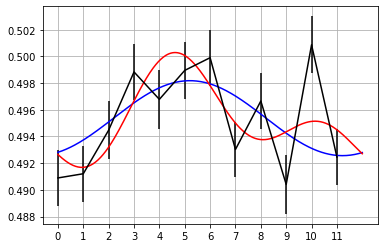

[-133.550177839746, -128.095168931210, -135.004267543702]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
MAGNESIUM_BLOOD both


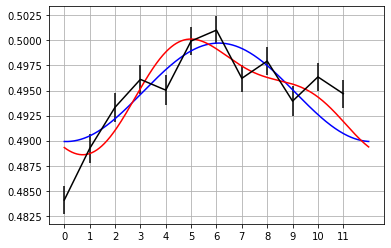

[-136.691681731782, -130.676668193958, -130.318095511969]
1st order cosinor
acrophase =  5.765664364851104
maxmin/2 =  0.008614096473981047
--------------
POTASSIUM female


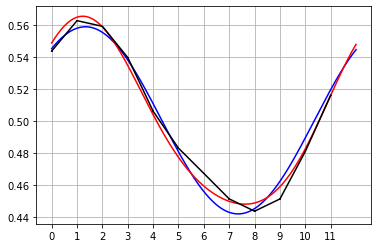

[-115.263028325466, -114.808200545957, -76.3193461403819]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05938954605003397
--------------
POTASSIUM male


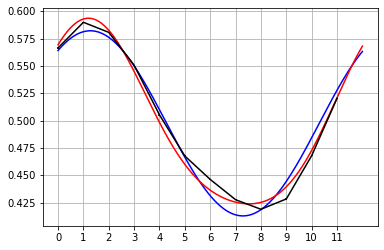

[-104.968892723020, -107.211844010089, -67.3738554805415]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.0853722476062194
--------------
POTASSIUM both


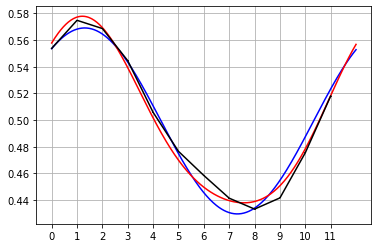

[-110.295298106973, -111.542658442675, -72.0327984623403]
2nd order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.0707433814128662
--------------
SODIUM female


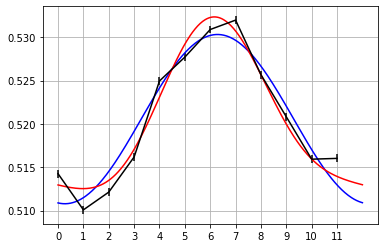

[-143.812365777410, -143.114395018552, -118.519020356490]
1st order cosinor
acrophase =  6.957740839594119
maxmin/2 =  0.010941914626595946
--------------
SODIUM male


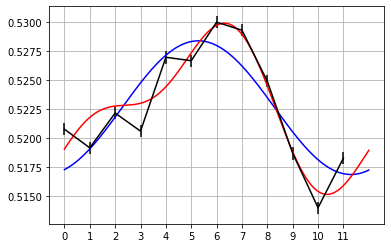

[-139.144857183452, -140.767104506776, -128.427845503622]
2nd order cosinor
acrophase =  6.1776269393112075
maxmin/2 =  0.008082336942851336
--------------
SODIUM both


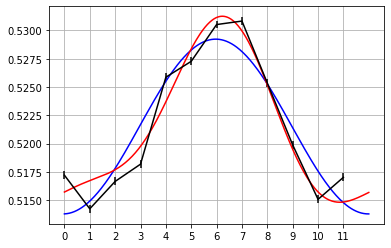

[-143.458389642982, -143.437610627834, -123.548741565751]
1st order cosinor
acrophase =  6.784455135550403
maxmin/2 =  0.008330449308478602
--------------
UREA_BLOOD female


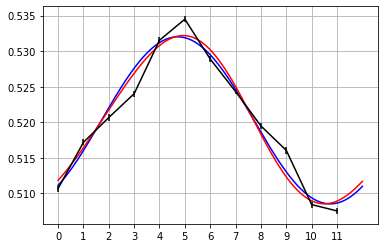

[-146.963530381309, -138.148773069111, -114.547592781487]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.013526393749170829
--------------
UREA_BLOOD male


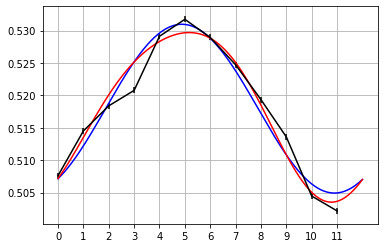

[-142.803845239974, -137.353173541340, -112.007199184776]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.01479552809487275
--------------
UREA_BLOOD both


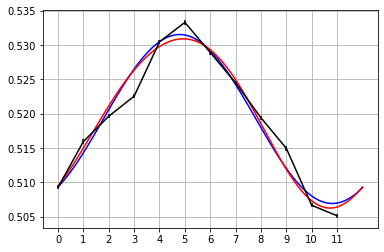

[-145.985909229317, -138.291952429786, -113.448136112097]
1st order cosinor
acrophase =  5.0
maxmin/2 =  0.014062044202610605



In [3]:
effector_list  = gen_hormone_list(effector_hormone_dic)
pituitary_list = gen_hormone_list(pituitary_hormone_dic)
residual_list  = gen_hormone_list(residual_hormone_dic)
chem_list      = gen_hormone_list(chem_dic)
pickle.dump([pituitary_list,effector_list,residual_list,chem_list],open('seasonality_processed_data2801_20_80.pickle','wb'))

In [15]:
[pituitary_list,effector_list,residual_list,chem_list] = pickle.load(open('seasonality_processed_data2801_20_60.pickle','rb'))

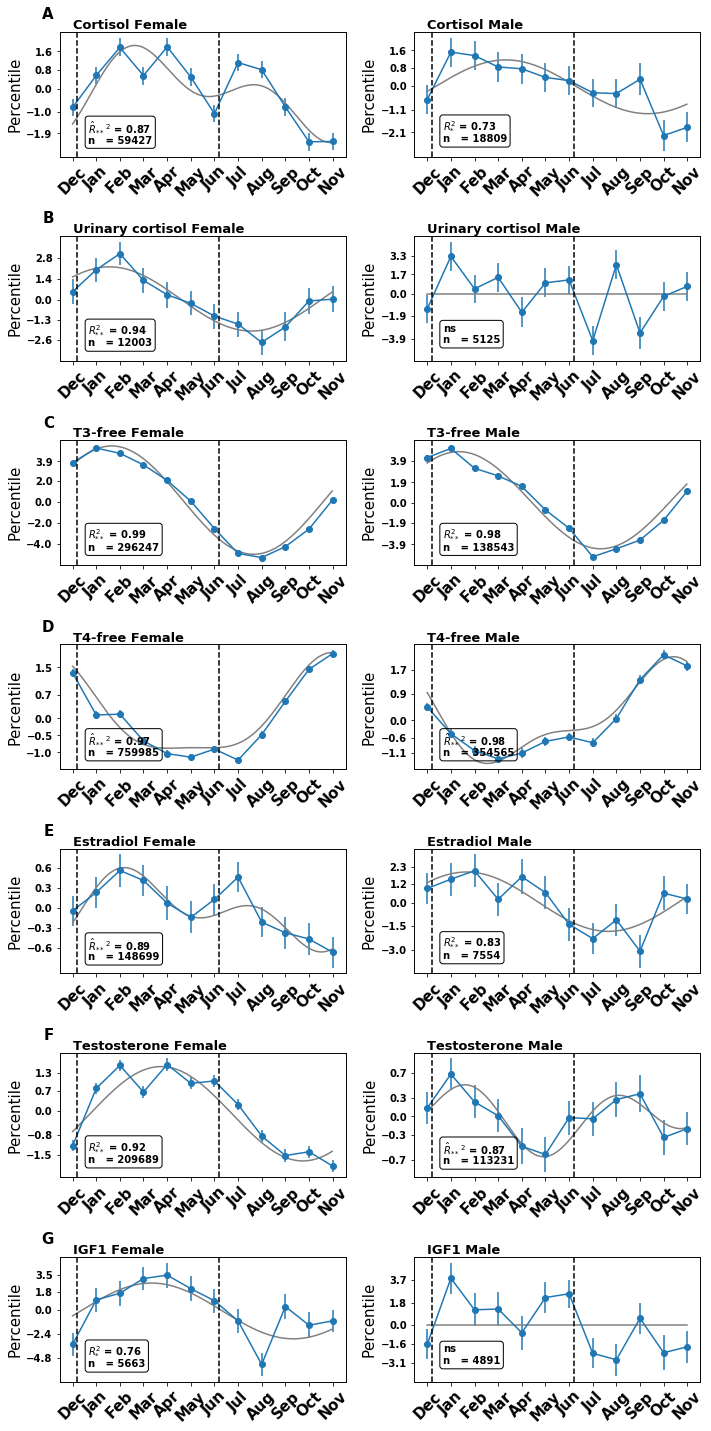

In [16]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]
                
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        y_percentage   = (yloc-yloc.mean())*100;
        err_precentage = err*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/Seasonality28012020/SI_effector_subplots_2801.png',bbox_inches='tight',dpi=600)
plt.show()

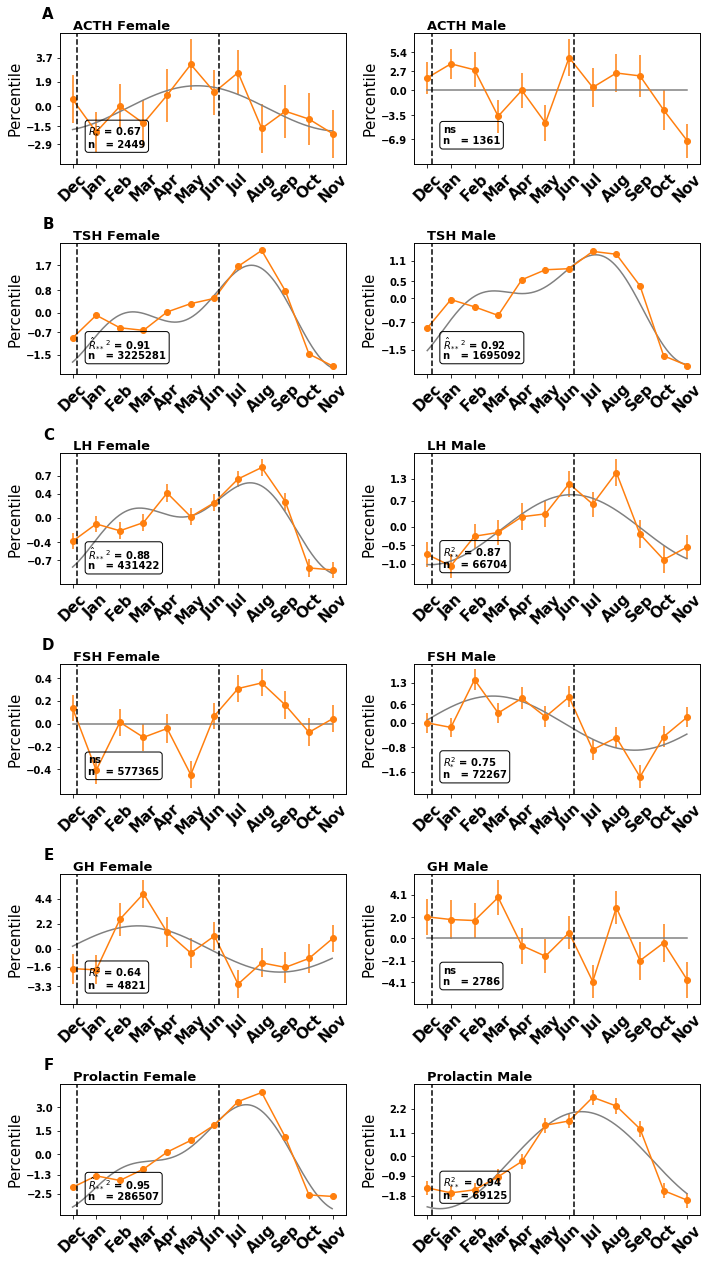

In [17]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
            
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100

        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/Seasonality28012020/SI_pituitary_subplots_2801.png',bbox_inches='tight',dpi=600)
plt.show()

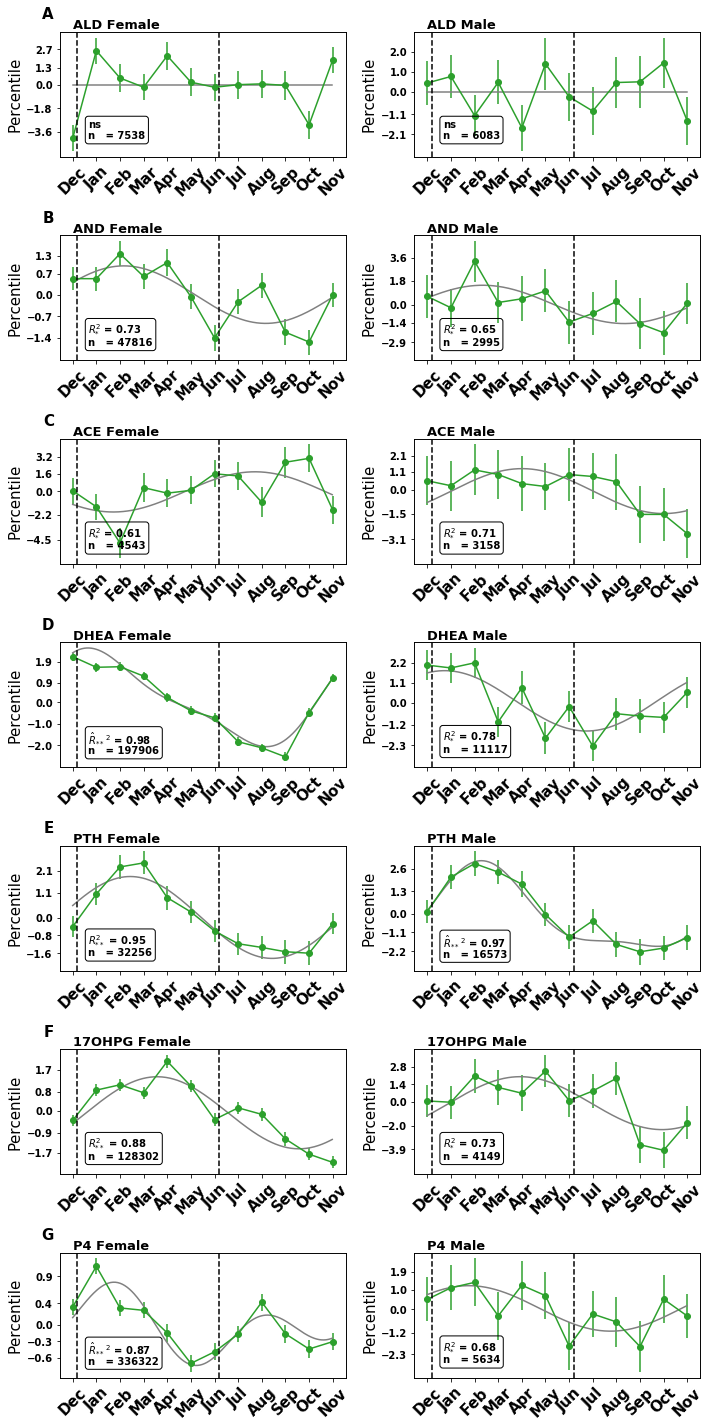

In [18]:
'''
plot residual hormones seasonality
'''
residual_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(residual_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = residual_list[residual_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = residual_list[residual_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = residual_list[residual_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = residual_list[residual_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        residual_r2df = residual_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100
        err_precentage = err*100

        #plot
        ax = plt.subplot(9,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[2],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(residual_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
         
plt.tight_layout()
plt.savefig('../figures/Seasonality28012020/SI_residual_subplots_2801.png',bbox_inches='tight',dpi=600)
plt.show()

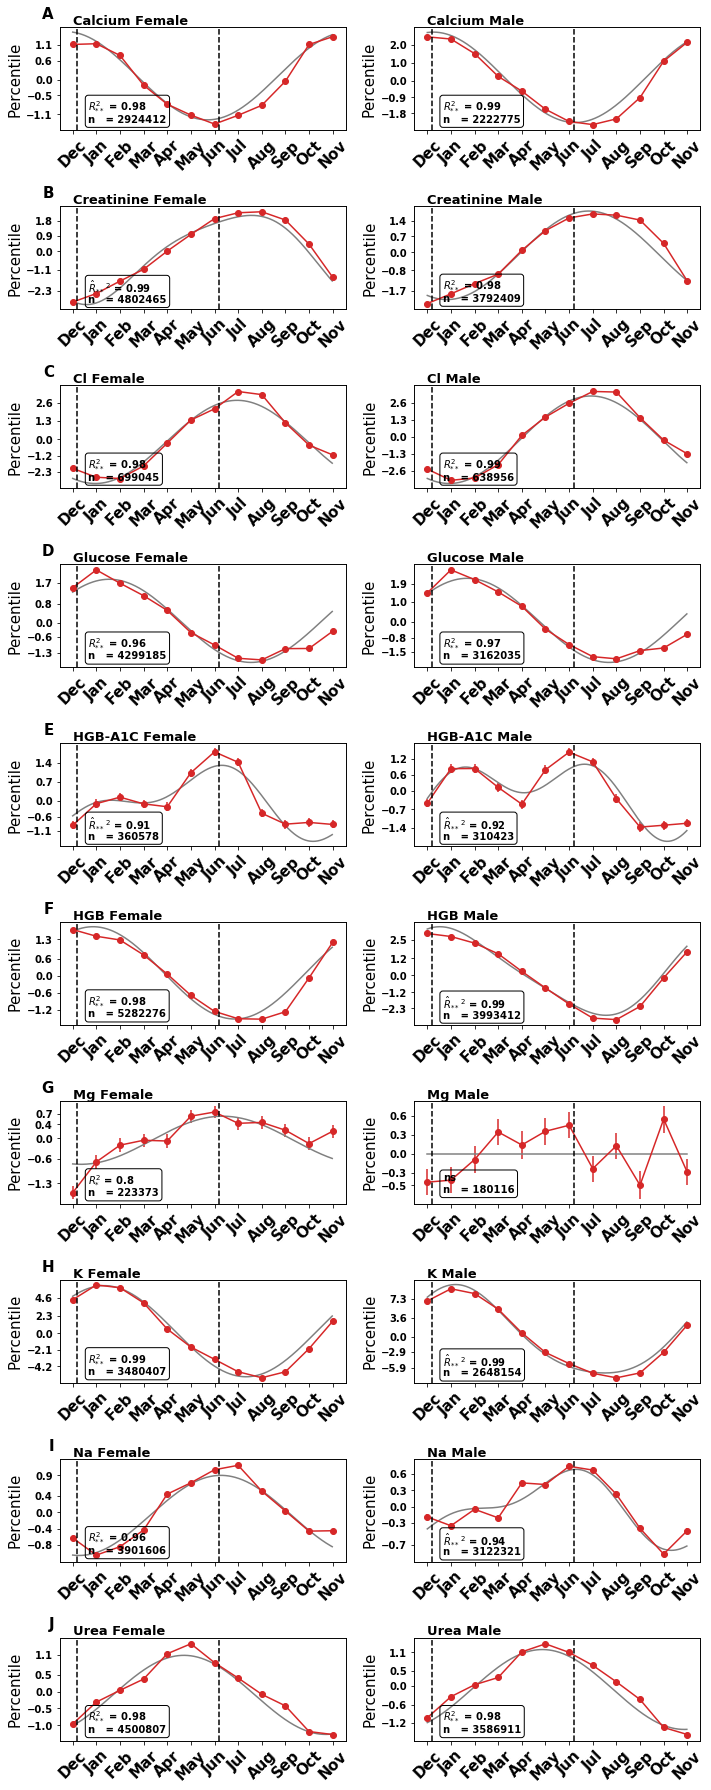

In [19]:
'''
plot chemistry seasonality
'''
chem_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])
plt.figure(figsize=(10,25))
for j,k in tqdm(enumerate(chem_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = chem_list[chem_dic[k]][sex]['Clalit']['xloc']
        yloc    = chem_list[chem_dic[k]][sex]['Clalit']['yloc']
        err     = chem_list[chem_dic[k]][sex]['Clalit']['err']
        ntot    = chem_list[chem_dic[k]][sex]['Clalit']['ntot']
        phase   = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = chem_list[chem_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = chem_list[chem_dic[k]][sex]['Cosinor2']['pars'][0][1]
        
        p        = ((phase)/12)*2*np.pi 
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        chem_r2df = chem_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        

        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100
        #plot
        ax = plt.subplot(10,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[3],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        axn.annotate(chem_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')
       
plt.tight_layout()
plt.savefig('../figures/Seasonality28012020/SI_chemistry_subplots_2801.png',bbox_inches='tight',dpi=600)
plt.show()

# FIG 1 complete

In [20]:
 def HPA_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cortisol',[-1.12+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.725, 0.2, 0.2], anchor='SW', zorder=-1)
    
    newax.imshow(plt.imread('../figures/ppt/glands/adrenal.png'))
    
    newax.text(0.2, 1.08, 'Stress adaptation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    
    newax.text(0.2, 0.2, 'Adrenal Cortex', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    

    newax.text(0.16, 1.09, 'A', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')

    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def HPT_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'   ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4',[-0.87+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.528, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/thyroid.png'))
    
    newax.text(0.2, 1.08, 'Thermoregulation \n   & metabolism', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, 'Thyroid', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'B', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)
    
def HPG_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.9+xoff ,-0.15+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.9+xoff ,-0.35+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.357, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/gonads.png'))
    
    newax.text(0.2, 1.08, 'Reproduction', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, '  Gonads', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'C', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    

def HPL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.6     
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-1.05+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.133, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/liver.png'))
    
    newax.text(0.2, 1.08, 'Growth', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.56, '    Liver', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'D', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def PRL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.45 
    ax.annotate('H'    ,[-1   +xoff,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1   +xoff,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-1.05+xoff,-0.45+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, 0.3 +Yoff],
                xy    =[-0.97  +xoff,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, -0.1 +Yoff],
                xy    =[-0.97  +xoff,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))

    newax = fig.add_axes([-0.2, 0.035, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/breasts.png'))
    
    newax.text(0.2, 1.08, 'Lactation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.45, '    Breasts', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'E', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    
        
def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False,fontsize=15):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,mec='k')
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=fontsize)
    

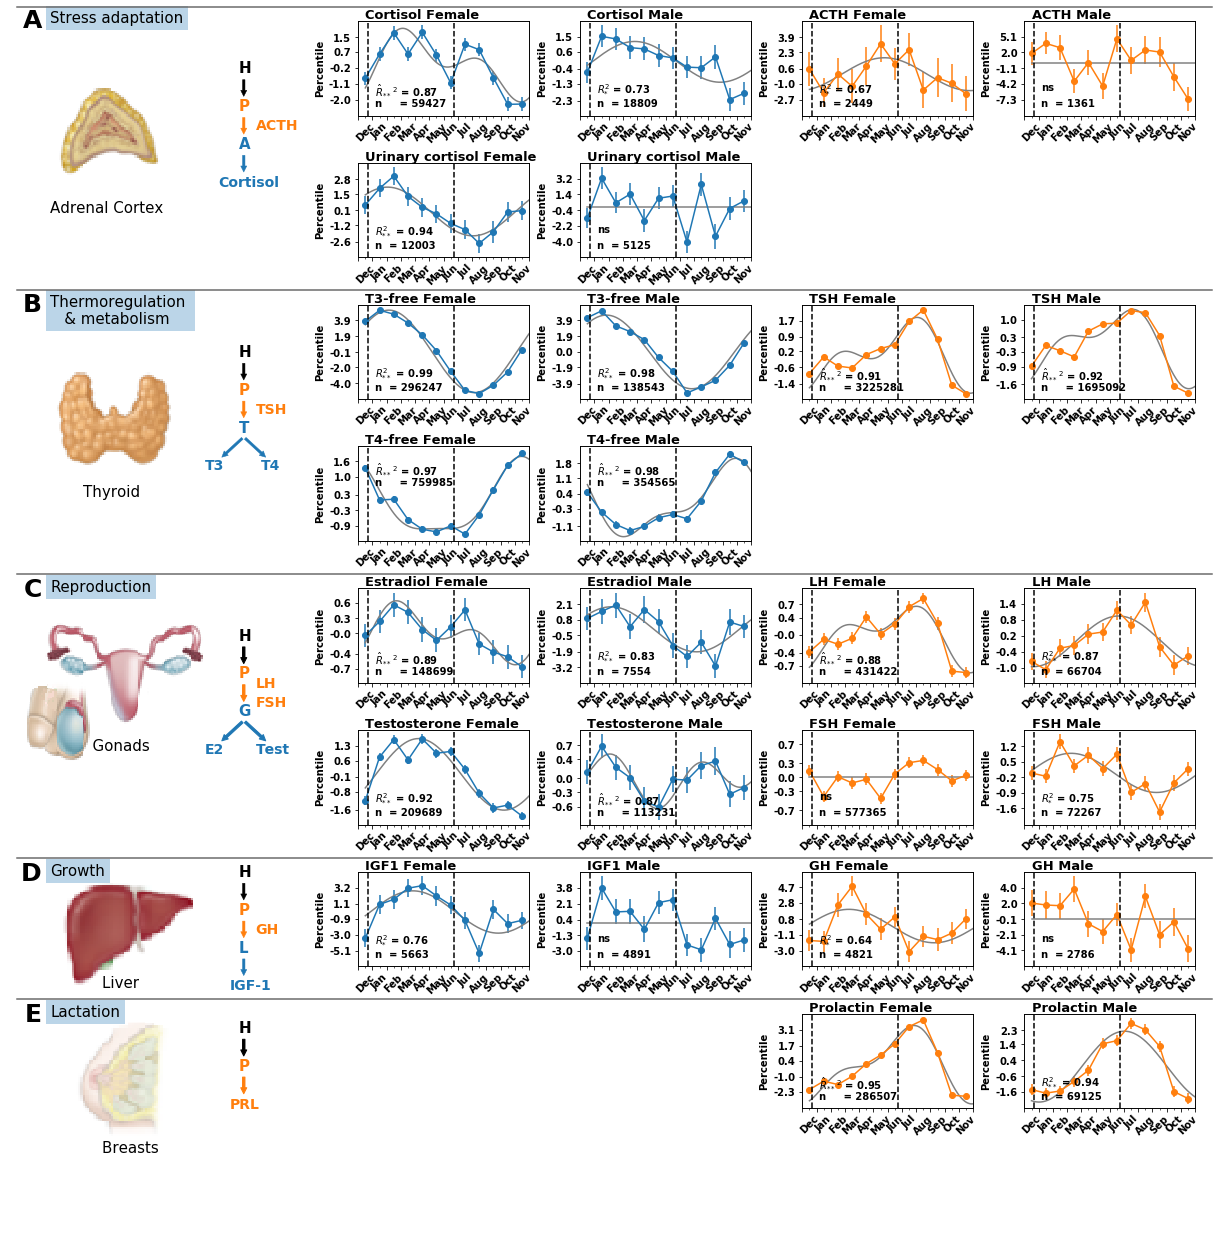

In [25]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[7,0]); PRL_graph_on_axe(ax,fig);  ax.axis('off')
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
           
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(effector_unit_dict[effector_hormone_dic[k]],fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 
            
        if k == 'T4_FREE':
            ax.text(0.1, 0.85, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.675, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        else:
            ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)

        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100;  fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel(pituitary_unit_dict[pituitary_hormone_dic[k]],fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        if ax.get_ylim()[1]<0.7:
            ax.set_ylim([-1,1])
        
        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        
        axn = ax.twinx(); axn.set_yticks([]); 
        axn.axvline(x=0.2,ls='--',c='k'); axn.axvline(x=6.2,ls='--',c='k')
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 

        ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

plt.subplots_adjust(hspace=0.5,wspace =0.3)
plt.savefig('../figures/Seasonality28012020/Figure1_2801_20_60.png',bbox_inches='tight',dpi=600)
plt.show()

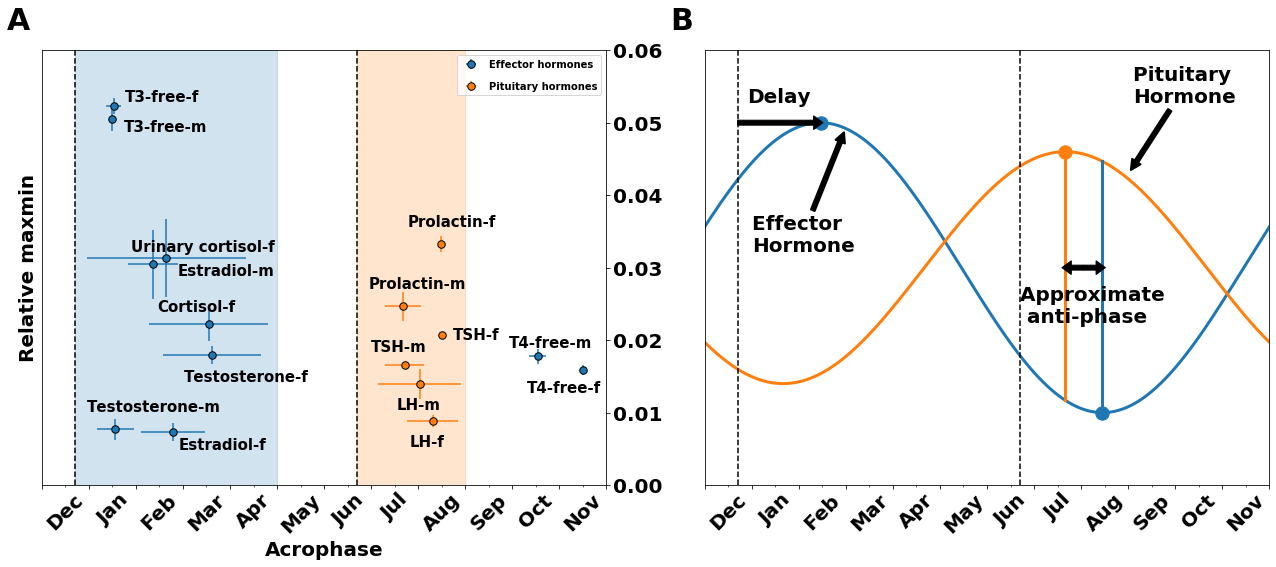

In [23]:
'''
FIG 2AB -  Code to phase plot, and summery
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(22,8))
gs  = fig.add_gridspec(4, 6)

uy = 0.06/100
ux = 12/100
pit_loc = [(2*ux,-uy),(-6*ux,3*uy),(-4*ux,-6*uy),(-4*ux,-6*uy),(-6*ux,4*uy),(-6*ux,4*uy)]
eff_loc = [(-9*ux,3*uy),(ux*-4,3*uy),(ux*2,1*uy),(2*ux,-3*uy),(-10*ux,-5*uy),(-5*ux,2*uy),(ux,-4*uy),(2*ux,-4*uy),(-5*ux,-6*uy),(-5*ux,4*uy)]

temp    = eff_r2df.loc[eff_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
eff_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

temp    = pit_r2df.loc[pit_r2df['sex']!='both']
temp    = temp[temp['r2']>0.8]
pit_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]

eff_rel_maxmin     = []
eff_acrophase      = []
eff_rel_maxmin_std = []
eff_acrophase_std  = []
eff_names          = []

for hormone in eff_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    eff_rel_maxmin    .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    eff_acrophase     .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    eff_rel_maxmin_std.append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    eff_acrophase_std .append(effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    eff_names         .append(effector_hormone_dic[name] +"-"+ sex_one_letter)

pit_rel_maxmin     = []
pit_acrophase      = []
pit_rel_maxmin_std = []
pit_acrophase_std  = []
pit_names          = []

for hormone in pit_big:
    name = hormone[0]
    if name == 'GROWTH_HORMONE_GH':
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    sex_one_letter = sex[0]
    pit_rel_maxmin    .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3])
    pit_acrophase     .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2])
    pit_rel_maxmin_std.append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][3])
    pit_acrophase_std .append(pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][1][2])
    pit_names         .append(pituitary_hormone_dic[name]+ '-'+ sex_one_letter)


'''
FIG 2A -  Code to plot phase/amp 
'''
axbig = fig.add_subplot(gs[:,:3])
ax    = fig.add_subplot(gs[:,3:])

plot_phase_amp(axbig,
               np.array(eff_rel_maxmin),
               np.array(eff_acrophase), 
               np.array(eff_rel_maxmin_std),
               np.array(eff_acrophase_std),
               eff_names,
               color=def_color[0],
               loc_list=eff_loc)

plot_phase_amp(axbig,
               np.array(pit_rel_maxmin),
               np.array(pit_acrophase), 
               np.array(pit_rel_maxmin_std),
               np.array(pit_acrophase_std),
               pit_names,
               color=def_color[1],
               loc_list=pit_loc)

month_names0  = np.roll(month_names,1)
axbig.legend(['Effector hormones','Pituitary hormones'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
# axbig.tick_params(which='minor', length=8,labelsize =20)
# axbig.tick_params(which='major', length=0,labelsize =20)
axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 20,'fontweight':'bold'})
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

axbig.set_xticks(np.arange(12))
axbig.set_xticklabels(month_names0, rotation=45)
axbig.tick_params(axis='x',labelsize =20)
axbig.tick_params(axis='y',labelsize =20)

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(0.2, 4.5  , alpha=0.2, color=def_color[0])
axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 8.5, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,13,1)-0.5)
axbig.set_xticklabels([])
axbig.set_xticks(np.arange(0,12,1),minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)
axbig.set_xlim([-0.5,11.5])
###########################################
###########################################
###########################################

'''
FIG 2B -  Code to calculate average effector hormones seasonality
'''
stack_eff_cos = []
stack_pit_cos = [] 
                                              
for j,hormone in enumerate(eff_big):
    name = hormone[0]
    if name in ['T3_FREE','T4_FREE','ESTRADIOL_E_2','TESTOSTERONE_TOTAL']:
        continue
    sex  = hormone[1]
    acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_eff_cos.append([acrophase,relmaxmin])            
    
for j,hormone in enumerate(pit_big):
    name = hormone[0]
    if name in ['TSH_THYROID_STIMULATING_HORMONE','GROWTH_HORMONE_GH','PROLACTIN']:
        continue    
    sex  = hormone[1]
    if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
        if sex =='male':
            continue
    acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
    relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
    stack_pit_cos.append([acrophase,relmaxmin])

p         = circmean(np.array(stack_eff_cos)[:,0],high=12, low=0)*2*np.pi/12
relmaxmin =  np.mean(np.array(stack_eff_cos)[:,1])     
eff_cos   = 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
eff_cos   = np.insert(eff_cos, 365, eff_cos[0])

ax.plot(np.arange(0,12,12/365),eff_cos,color=def_color[0],linewidth = 3) 

p         = circmean(np.array(stack_pit_cos)[:,0],high=12, low=0)*2*np.pi/12
# relmaxmin =  np.mean(np.array(stack_pit_cos)[:,1])   
pit_cos   = 1+0.8*relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
pit_cos   = np.insert(pit_cos, 365, pit_cos[0])

ax.plot(np.arange(0,12,12/365),pit_cos,color=def_color[1],linewidth = 3)

mn = np.roll(month_names,1)
mn = np.insert(mn, 12, mn[0])
ax.set_yticks([])

ax.set_xticks(0.5+np.arange(12))
ax.set_xticklabels(mn, rotation=45)
ax.set_xlim([0,12])
ax.set_ylim([1-relmaxmin*1.5,1+relmaxmin*1.5])

ax.tick_params(axis='x',labelsize =20)

ax.arrow(0.7, eff_cos.max(), eff_cos.argmax()*12/365-0.85, 0,head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.annotate('Delay',[0.9,1.03],fontsize=20)

ax.annotate('Pituitary \nHormone',fontsize=20,
            xy=(9, pit_cos[9*30]), xycoords='data',
            xytext=(9.1, 1.03), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.annotate('Effector \nHormone',fontsize=20,
            xy=(3, eff_cos[3*30]), xycoords='data',
            xytext=(1, 1.003), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            color="0",
                            shrinkB=5,linewidth = 2,
                            connectionstyle="arc3,rad=0"),)

ax.scatter(eff_cos.argmax()*12/365, eff_cos.max(),s=180,c=def_color[0])
ax.scatter(eff_cos.argmin()*12/365, eff_cos.min(),s=180,c=def_color[0])
ax.scatter(pit_cos.argmax()*12/365, pit_cos.max(),s=180,c=def_color[1])

ax.plot([pit_cos.argmax()*12/365,pit_cos.argmax()*12/365],[pit_cos.max(),eff_cos[pit_cos.argmax()]],c=def_color[1],lw='3')
ax.plot([eff_cos.argmin()*12/365,eff_cos.argmin()*12/365],[eff_cos.min(),pit_cos[eff_cos.argmin()]],c=def_color[0],lw='3')

ax.annotate('Approximate \n anti-phase',[6.7,0.99],fontsize=20)

mid    = np.mean([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])
ar_len = np.diff([pit_cos.argmax()*12/365,eff_cos.argmin()*12/365])[0]/3

ax.arrow(mid, 1, ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)
ax.arrow(mid, 1, -ar_len, 0, head_width=0.0025, head_length=0.2 , width=0.0009, fc='k', ec='k', zorder=4)

ax.text(-0.02, 1.1, 'B', transform=ax.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax.axvline(x=0.7,ls='--',c='k')
ax.axvline(x=6.7,ls='--',c='k')

ax.set_xticks(np.arange(0,13,1))
ax.set_xticklabels([])
ax.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=20,fontweight='bold',minor =True)

plt.subplots_adjust(hspace=0.4,wspace =0.8)
plt.savefig('../figures/Seasonality28012020/Figure2AB_2801.png',bbox_inches='tight',dpi=600)
plt.show()

In [27]:
chem_names

['Calcium-f',
 'Calcium-m',
 'Creatinine-f',
 'Creatinine-m',
 'Cl-f',
 'Cl-m',
 'Glucose-f',
 'Glucose-m',
 'HGB-A1C-f',
 'HGB-A1C-m',
 'HGB-f',
 'HGB-m',
 'Mg-f',
 'K-f',
 'K-m',
 'Na-f',
 'Na-m',
 'Urea-f',
 'Urea-m']

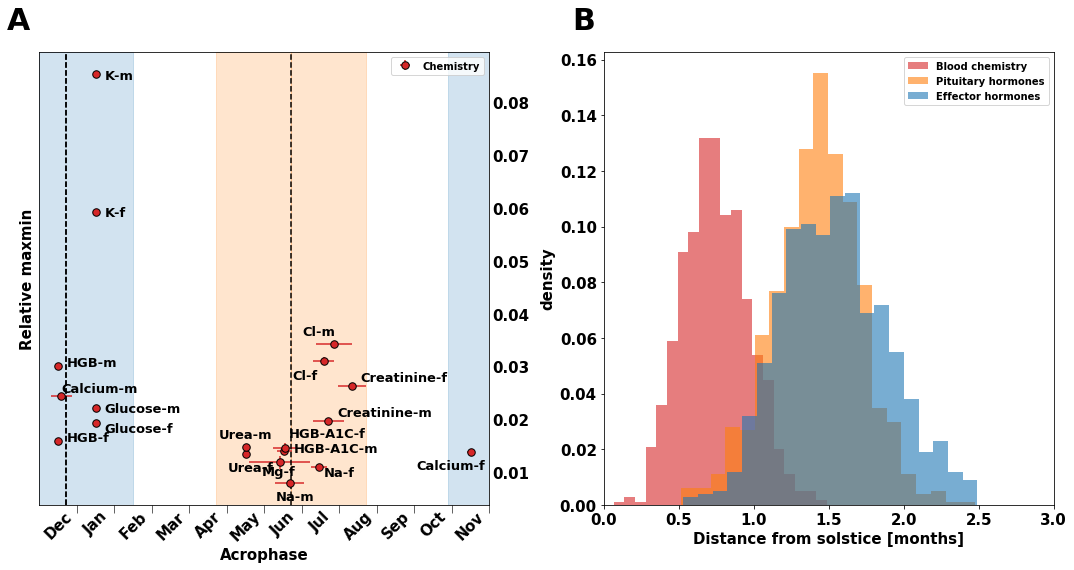

effector & chemistry,  Ks_2sampResult(statistic=0.847, pvalue=1.751302865e-315)
pituitary & effector,  Ks_2sampResult(statistic=0.15800000000000003, pvalue=2.1768484378396996e-11)


In [95]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
                            
chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
# plt.show()

dec21 = 0.2
jun21 = 6.2
dec21B = 12.2
def distance_from_solstice(acrophases_list):
    return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

Dche = []
for bootstrap in range(1000):
    chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
    chem_acrophase_boot = chem_acrophase_boot[np.random.randint(0,len(chem_acrophase_boot),5)]
    Dche += [np.sum(distance_from_solstice(chem_acrophase_boot))/len(chem_acrophase_boot)]

Deff = []
for bootstrap in range(1000):
    eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
    eff_acrophase_boot = eff_acrophase_boot[np.random.randint(0,len(eff_acrophase_boot),5)]
    Deff += [np.sum(distance_from_solstice(eff_acrophase_boot))/len(eff_acrophase_boot)]
    
Dpit = []
for bootstrap in range(1000):
    pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
    pit_acrophase_boot = pit_acrophase_boot[np.random.randint(0,len(pit_acrophase_boot),5)]
    Dpit += [np.sum(distance_from_solstice(pit_acrophase_boot))/len(pit_acrophase_boot)]
    
eff_weights = np.ones_like(Deff)/float(len(Deff))
pit_weights = np.ones_like(Dpit)/float(len(Dpit))
che_weights = np.ones_like(Dche)/float(len(Dche))

ax1 = plt.subplot(1,2,2);
ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax1.hist(Dche,color=def_color[3],alpha=0.6,bins=20,weights=che_weights);
ax1.hist(Dpit,color=def_color[1],alpha=0.6,bins=20,weights=pit_weights);
ax1.hist(Deff,color=def_color[0],alpha=0.6,bins=20,weights=eff_weights); 
ax1.set_xlim([0,3])
ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
ax1.set_ylabel('density',fontsize=15,fontweight='bold')
ax1.tick_params(axis='x',labelsize =15)
ax1.tick_params(axis='y',labelsize =15)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
plt.show()

print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
print('pituitary & effector, ',stats.ks_2samp(Dpit, Deff))

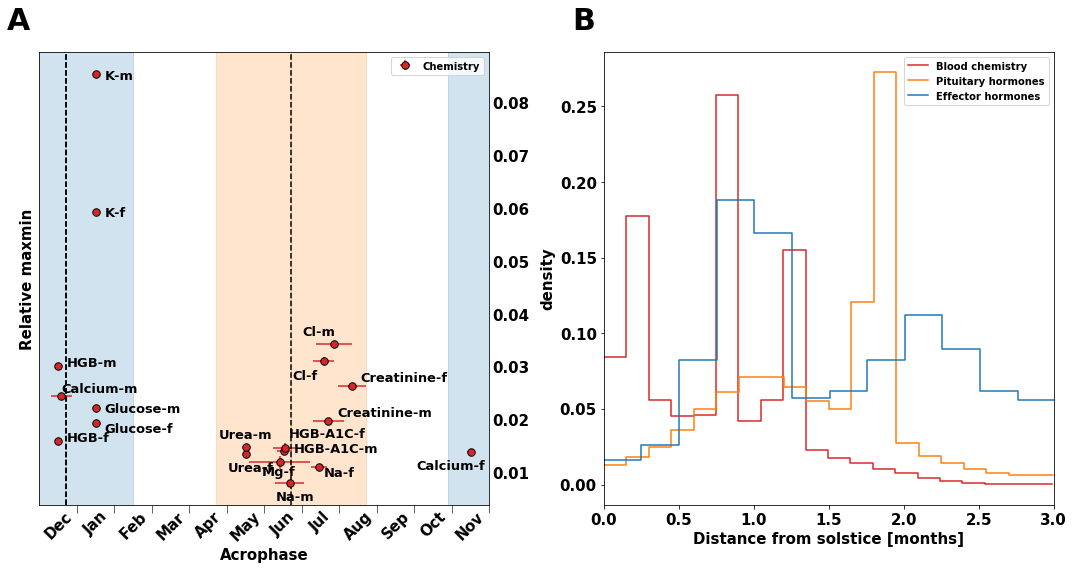

effector & chemistry,  Ks_2sampResult(statistic=0.4553673684210527, pvalue=0.0)
pituitary & effector,  Ks_2sampResult(statistic=0.25307999999999997, pvalue=0.0)


In [96]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
                            
chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
# plt.show()

dec21 = 0.2
jun21 = 6.2
dec21B = 12.2
def distance_from_solstice(acrophases_list):
    return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

Dche = []; Deff = []; Dpit = []
for bootstrap in range(10000):
    chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
    Dche += distance_from_solstice(chem_acrophase_boot)

    eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
    Deff += distance_from_solstice(eff_acrophase_boot)
    
    pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
    Dpit += distance_from_solstice(pit_acrophase_boot)
    
eff_weights = np.ones_like(Deff)/float(len(Deff))
pit_weights = np.ones_like(Dpit)/float(len(Dpit))
che_weights = np.ones_like(Dche)/float(len(Dche))

ax1 = plt.subplot(1,2,2);
ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

bins, edges  = np.histogram(Dche,bins=20,weights=che_weights); left,right   = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten(); Y = np.array([bins,bins]).T.flatten()
ax1.plot(X,Y,c=def_color[3])

bins, edges  = np.histogram(Dpit,bins=20,weights=pit_weights); left,right   = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten(); Y = np.array([bins,bins]).T.flatten()
ax1.plot(X,Y,c=def_color[1])

bins, edges  = np.histogram(Deff,bins=20,weights=eff_weights); left,right   = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten(); Y = np.array([bins,bins]).T.flatten()
ax1.plot(X,Y,c=def_color[0])

ax1.set_xlim([0,3])
ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
ax1.set_ylabel('density',fontsize=15,fontweight='bold')
ax1.tick_params(axis='x',labelsize =15)
ax1.tick_params(axis='y',labelsize =15)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
plt.show()

print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
print('pituitary & effector, ',stats.ks_2samp(Dpit, Deff))

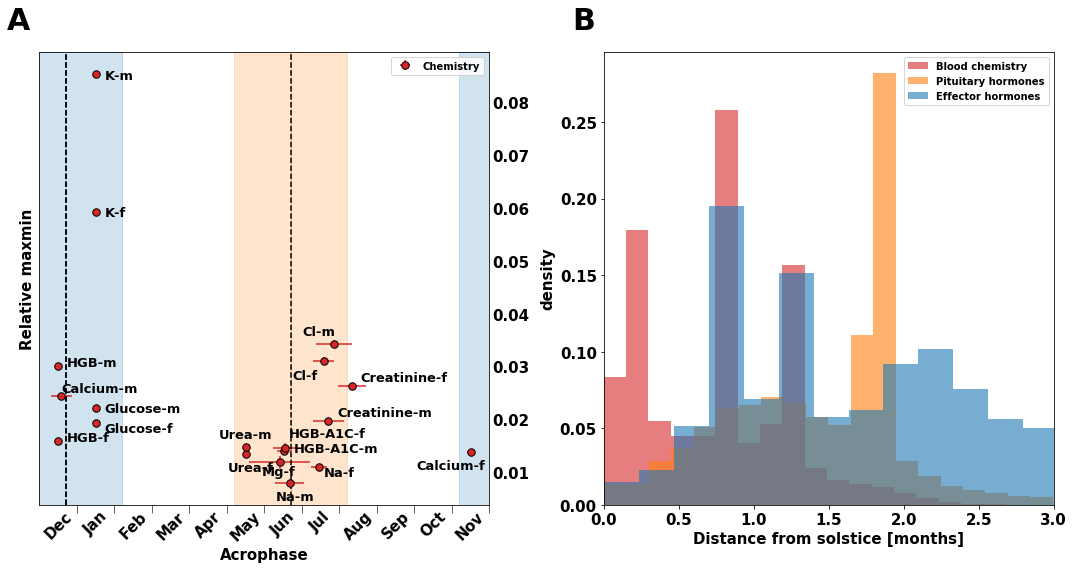

effector & chemistry,  Ks_2sampResult(statistic=0.46025789473684214, pvalue=0.0)
pituitary & chemistry,  Ks_2sampResult(statistic=0.2612, pvalue=1.5548349221249486e-223)


In [102]:
temp    = chem_r2df.loc[chem_r2df['sex']!='both']
temp    = temp[temp['r2']>0.4]
chem_big = [[temp.iloc[i]['hormone'],temp.iloc[i]['sex']] for i in range(len(temp))]
uy = 0.085/100
ux = 12/100
chem_loc = [(-12*ux,-4*uy),(0,uy),(2*ux,uy),(2*ux,uy),(-7*ux,-4*uy),(-7*ux,2*uy),(2*ux,-2*uy),(2*ux,-uy),
            (1*ux,3*uy),(2*ux,-1*uy),(2*ux,0),(2*ux,0),(-4*ux,-3*uy),(2*ux,-uy),(2*ux,-uy),(1*ux,-2*uy),(-3*ux,-4*uy),(-4*ux,-4*uy),(-6*ux,2*uy)]
                            
chem_rel_maxmin     = []
chem_acrophase      = []
chem_rel_maxmin_std = []
chem_acrophase_std  = []
chem_names          = []

for hormone in chem_big:
    name = hormone[0]
    sex  = hormone[1]
    sex_one_letter = sex[0]
    chem_rel_maxmin    .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][3])
    chem_acrophase     .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][0][2])
    chem_rel_maxmin_std.append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][3])
    chem_acrophase_std .append(chem_list[chem_dic[name]][sex]['Cosinor']['pars'][1][2])
    chem_names         .append(chem_dic[name] +"-"+ sex_one_letter)
    
plt.figure(figsize = (15,8))   
axbig = plt.subplot(1,2,1)
    
plot_phase_amp(axbig,
           np.array(chem_rel_maxmin),
           np.array(chem_acrophase), 
           np.array(chem_rel_maxmin_std),
           np.array(chem_acrophase_std),
           chem_names,
           color=def_color[3],
           loc_list=chem_loc,fontsize=13)

month_names0  = np.roll(month_names,1)
axbig.legend(['Chemistry'],loc=1,fontsize='medium',labelspacing =1.2)#,bbox_to_anchor=(1,0.83))
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.yaxis.tick_right()
axbig.tick_params(which='minor', length=8,labelsize =15)
axbig.tick_params(which='major', length=0,labelsize =15)
# axbig.set_ylim((0,0.06))
axbig.set_ylabel('Relative maxmin',fontdict={'size': 15,'fontweight':'bold'})
axbig.set_xlabel('Acrophase'        ,fontdict={'size': 15,'fontweight':'bold'})

axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(-0.5, 1.7, alpha=0.2, color=def_color[0])
axbig.axvline(x=0.2,ls='--',c='k')
axbig.axvspan(10.7, 11.5  , alpha=0.2, color=def_color[0])

axbig.axvline(x=6.2,ls='--',c='k')
axbig.axvspan(6.2, 7.7, alpha=0.2, color=def_color[1])
axbig.axvspan(4.7, 6.2, alpha=0.2, color=def_color[1])

axbig.set_xticks(np.arange(0,12,1))
axbig.set_xticks(np.arange(0,12,1)+0.5,minor=True)
axbig.set_xticklabels(month_names0[::1], rotation=45,fontsize=15,fontweight='bold',minor =False)
axbig.set_xlim([-0.5,11.5])
axbig.text(-0.02, 1.1, 'A', transform=axbig.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')

# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
# plt.show()

dec21 = 0.2
jun21 = 6.2
dec21B = 12.2
def distance_from_solstice(acrophases_list):
    return [np.min(np.abs([dD1,dD2,dJ])) for dD1,dD2,dJ in zip(np.array(acrophases_list) - dec21,np.array(acrophases_list) - dec21B,np.array(acrophases_list) - jun21)]

Dche = []; Deff = []; Dpit = []

for bootstrap in range(1000):
    chem_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(chem_acrophase,np.abs(chem_acrophase_std))])
    Dche += distance_from_solstice(chem_acrophase_boot)

    eff_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(eff_acrophase,np.abs(eff_acrophase_std))])
    Deff += distance_from_solstice(eff_acrophase_boot)
    
    pit_acrophase_boot = np.array([np.random.normal(loc = y,scale = e) for y,e in zip(pit_acrophase,np.abs(pit_acrophase_std))])
    Dpit += distance_from_solstice(pit_acrophase_boot)
   
eff_weights = np.ones_like(Deff)/float(len(Deff))
pit_weights = np.ones_like(Dpit)/float(len(Dpit))
che_weights = np.ones_like(Dche)/float(len(Dche))

ax1 = plt.subplot(1,2,2);
ax1.text(-0.02, 1.1, 'B', transform=ax1.transAxes,fontsize = 30, fontweight='bold', va='top', ha='right')
ax1.hist(Dche,color=def_color[3],alpha=0.6,bins=20,weights=che_weights);
ax1.hist(Dpit,color=def_color[1],alpha=0.6,bins=20,weights=pit_weights);
ax1.hist(Deff,color=def_color[0],alpha=0.6,bins=20,weights=eff_weights); 
ax1.set_xlim([0,3])
ax1.legend(['Blood chemistry','Pituitary hormones','Effector hormones'])
ax1.set_xlabel('Distance from solstice [months]',fontsize=15,fontweight='bold')
ax1.set_ylabel('density',fontsize=15,fontweight='bold')
ax1.tick_params(axis='x',labelsize =15)
ax1.tick_params(axis='y',labelsize =15)
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
# plt.savefig('../figures/Seasonality28012020/SI_Chem_phase_amp_2801.png',bbox_inches='tight',dpi=600)
plt.show()

print('effector & chemistry, ', stats.ks_2samp(Deff, Dche))
print('pituitary & chemistry, ',stats.ks_2samp(Dpit, Deff))

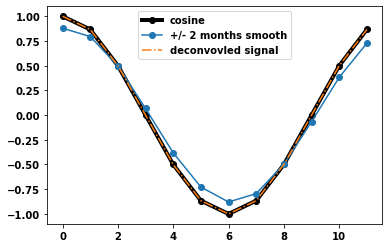

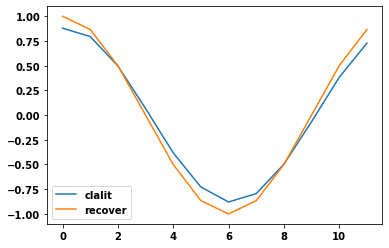

amplitude decreased by factor of 0.121

#######################################################
deconvolving T3_free


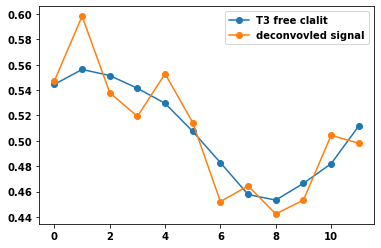

In [966]:
##cosine smoothing  effect over amplitude
## resulotion of months
date  = np.random.randint(0,12,10000)
y     = np.cos(date*2*np.pi/12)
ymean = [np.mean(y[date==m]) for m in range(12)]*10
plt.plot(ymean[12:12*2],'-ok',lw=4)

impulse_response = [4/13,4/13,4/13,1/13]

yclalit = np.roll(convolve(impulse_response, ymean),-2)
plt.plot(yclalit[12*8-1:12*8+11],'-o')

recovered, remainder = deconvolve(np.roll(yclalit,2), impulse_response)
plt.plot(recovered[12*8:12*9],'-.')
plt.legend(['cosine','+/- 2 months smooth','deconvovled signal'])
plt.show()

yclalit   = yclalit[12*8-1:12*8+11]
recovered = recovered[12*8:12*9]
plt.plot(yclalit)
plt.plot(recovered)
plt.legend(['clalit','recover'])
plt.show()
print('amplitude decreased by factor of '+str(1-np.round(yclalit.max()/recovered.max(),decimals=3)))
print('')
print('#######################################################')
print('deconvolving T3_free')

impulse_response = [4/13,4/13,4/13,1/13]

# yclalit =convolve(impulse_response, ymean)
yclalit = np.array(list(effector_list[effector_hormone_dic['T3_FREE']]['female']['Clalit']['yloc'])*10)

plt.plot(yclalit[12*8:12*9],'-o')

recovered, remainder = deconvolve(yclalit, impulse_response)
plt.plot(recovered[12*8-1:12*9-1],'-o')
plt.legend(['T3 free clalit','deconvovled signal'])
plt.show()

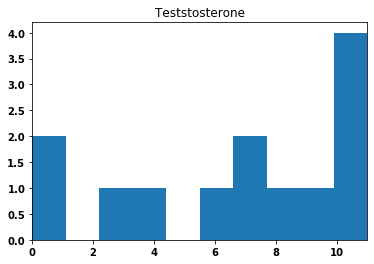

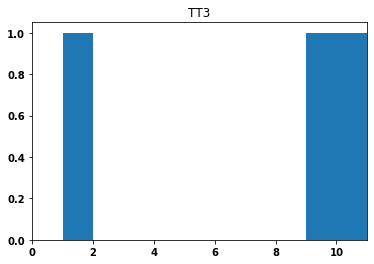

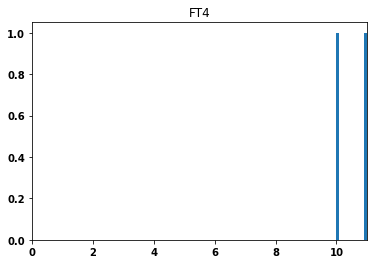

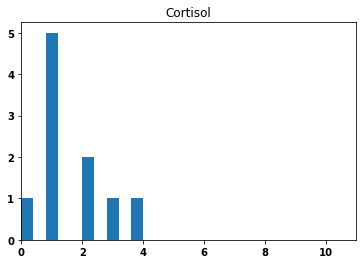

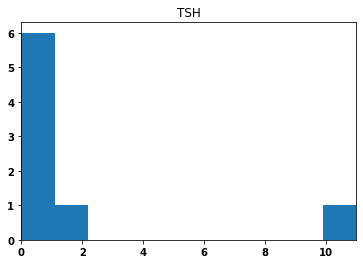

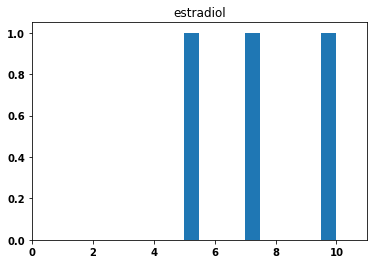

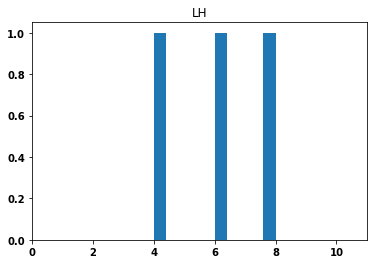

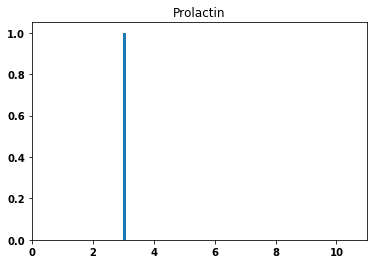

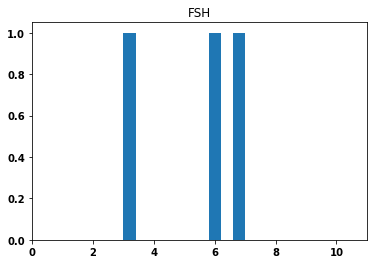

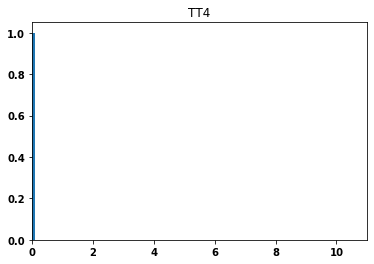

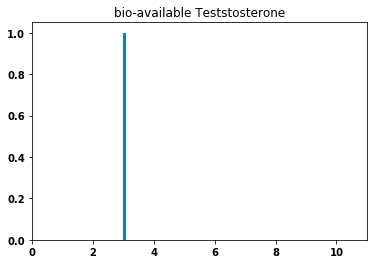

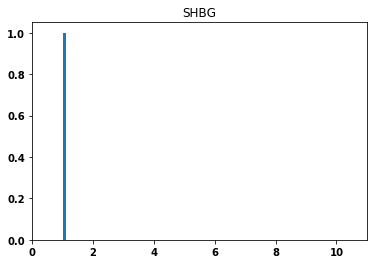

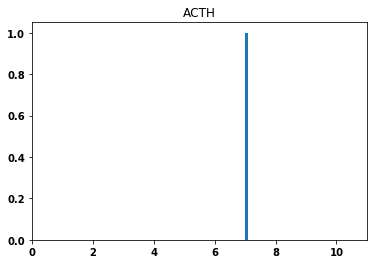

In [45]:
df = pd.read_excel('../HP seasonality review.xlsx')
df = df[['SEX','Hormone','latitude','amplitude']].copy()
df = df.loc[df['Hormone'] != '-']
df = df.dropna()

for hormone in list(set(df['Hormone'])):

    hdf = df.loc[df['Hormone']==hormone].copy()
    plt.scatter(np.abs(hdf['latitude'].values),hdf['amplitude'].values)
    plt.title(hormone)
    plt.xlabel('latitude')
    plt.ylabel('amplitude')
    plt.show()

df = pd.read_excel('../HP seasonality review.xlsx')
df = df[['SEX','Hormone','latitude','Acrophase']].copy()
df = df.loc[df['Hormone'] != '-']
df = df.loc[df['Acrophase'] != 'winter and summer peak']
df = df.loc[df['Hormone'] != 'TRH test']

seas = {'Spring':'April',
        'Summer':'July',
        'Fall'  :'October',
        'Winter':'January'}

for sea in seas:
    df.loc[df['Acrophase'] == sea,['Acrophase']] = seas[sea]

df['Acrophase'] = [month[:3] for month in df['Acrophase']]   

month_place = {'Dec':0,
               'Jan':1,
               'Feb':2,
               'Mar':3,
               'Apr':4,               
               'May':5,
               'Jun':6,
               'Jul':7,
               'Aug':8,
               'Sep':9,
               'Oct':10,
               'Nov':11}

df['Acrophase_i'] = [month_place[month] for month in df['Acrophase']]   

df.loc[df['latitude']<0,['Acrophase_i']] = df.loc[df['latitude']<0,['Acrophase_i']] - 6

for hormone in list(set(df['Hormone'])):
    hdf = df.loc[df['Hormone']==hormone].copy()
    plt.hist(hdf['Acrophase_i'])
    plt.title(hormone)
    plt.xlim([0,11])
    plt.show()
    
## add results of clalit acrophase


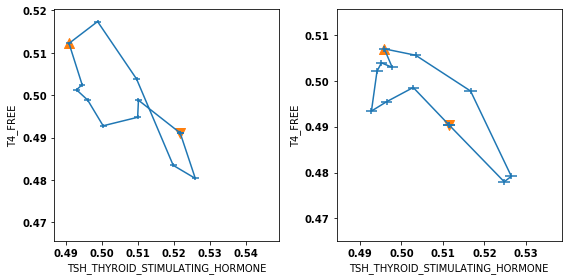

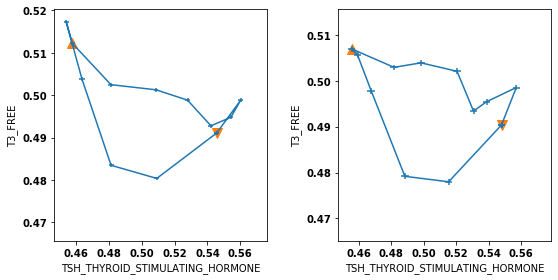

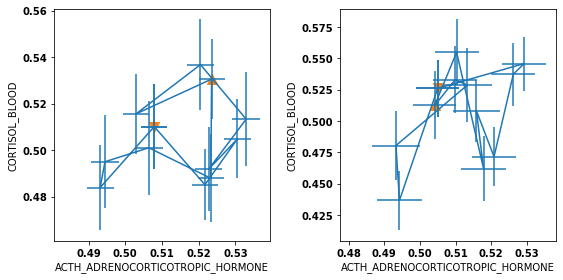

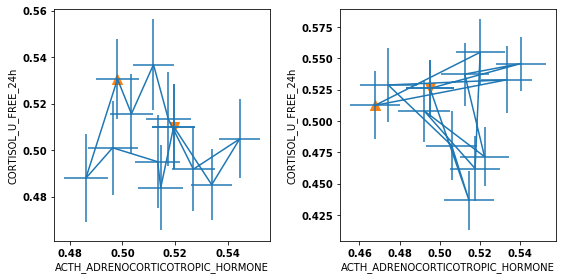

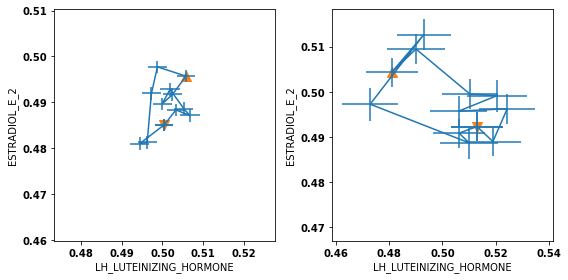

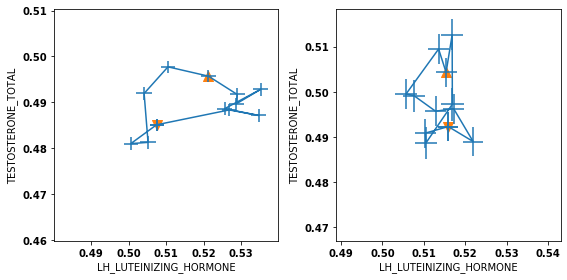

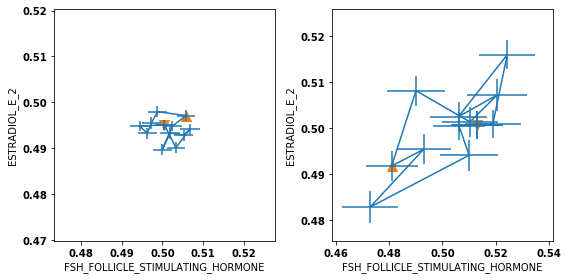

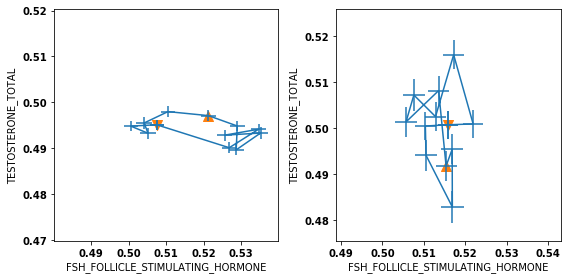

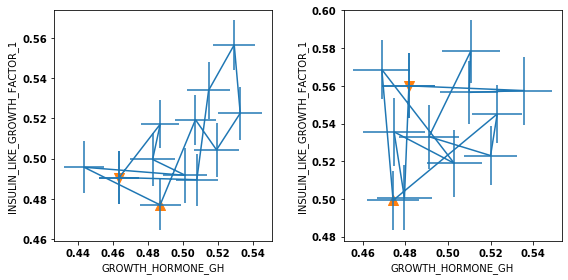

In [166]:
pairs = [['TSH_THYROID_STIMULATING_HORMONE' ,'T4_FREE'],
         ['TSH_THYROID_STIMULATING_HORMONE' ,'T3_FREE'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_BLOOD'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_U_FREE_24h'],
         ['LH_LUTEINIZING_HORMONE'          ,'ESTRADIOL_E_2'],
         ['LH_LUTEINIZING_HORMONE'          ,'TESTOSTERONE_TOTAL'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','ESTRADIOL_E_2'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','TESTOSTERONE_TOTAL'],
         ['GROWTH_HORMONE_GH'               ,'INSULIN_LIKE_GROWTH_FACTOR_1']]


for pair in pairs:
    plt.figure(figsize=(8,4))
    for i,sex in enumerate(['female','male']):
        ax = plt.subplot(1,2,i+1)
        k   = pair[0]
        j   = pair[1]

        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        yloc    = np.insert(yloc, 12, yloc[0])
        yerr    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err'].values

        yerr    = np.insert(yerr, 12, yerr[0])

        xloc    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['yloc']
        xloc    = np.insert(xloc, 12, xloc[0])
        xerr    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['err'].values
        xerr    = np.insert(xerr, 12, xerr[0])

        ax.scatter(xloc[0],yloc[0],c=def_color[1],s=100,marker='v',zorder=1)
        ax.scatter(xloc[7],yloc[7],c=def_color[1],s=100,marker='^',zorder=1)
        ax.errorbar(xloc,yloc,yerr=yerr,xerr=xerr)

        ax.set_xlabel(k)
        ax.set_ylabel(j)

    plt.tight_layout()
    plt.show()

In [ ]:
pairs = [['TSH_THYROID_STIMULATING_HORMONE' ,'T4_FREE'],
         ['TSH_THYROID_STIMULATING_HORMONE' ,'T3_FREE'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_BLOOD'],
         ['ACTH_ADRENOCORTICOTROPIC_HORMONE','CORTISOL_U_FREE_24h'],
         ['LH_LUTEINIZING_HORMONE'          ,'ESTRADIOL_E_2'],
         ['LH_LUTEINIZING_HORMONE'          ,'TESTOSTERONE_TOTAL'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','ESTRADIOL_E_2'],
         ['FSH_FOLLICLE_STIMULATING_HORMONE','TESTOSTERONE_TOTAL'],
         ['GROWTH_HORMONE_GH'               ,'INSULIN_LIKE_GROWTH_FACTOR_1']]


for pair in pairs:
    plt.figure(figsize=(8,4))
    for i,sex in enumerate(['female','male']):
        ax = plt.subplot(1,2,i+1)
        k   = pair[0]
        j   = pair[1]

        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        yloc    = np.insert(yloc, 12, yloc[0])
        yerr    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err'].values

        yerr    = np.insert(yerr, 12, yerr[0])

        xloc    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['yloc']
        xloc    = np.insert(xloc, 12, xloc[0])
        xerr    = effector_list[effector_hormone_dic[j]][sex]['Clalit']['err'].values
        xerr    = np.insert(xerr, 12, xerr[0])

        ax.scatter(xloc[0],yloc[0],c=def_color[1],s=100,marker='v',zorder=1)
        ax.scatter(xloc[7],yloc[7],c=def_color[1],s=100,marker='^',zorder=1)
        ax.errorbar(xloc,yloc,yerr=yerr,xerr=xerr)

        ax.set_xlabel(k)
        ax.set_ylabel(j)

    plt.tight_layout()
    plt.show()

7

In [ ]:
# for j,hormone in enumerate(eff_big):
#     name = hormone[0]
#     sex  = hormone[1]
# #     if name == 'T4_FREE':
# #         continue  
#     acrophase = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = effector_list[effector_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     p     = (acrophase/12)*2*np.pi
#     cosine= 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
#     cosine= np.insert(cosine, 365, cosine[0])
#     stack_eff_cos.append(cosine)
    
# for j,hormone in enumerate(pit_big):
#     name = hormone[0]
#     if name == 'GROWTH_HORMONE_GH':
#         continue    
#     sex  = hormone[1]
#     if name == 'FSH_FOLLICLE_STIMULATING_HORMONE':
#         if sex =='male':
#             continue
#     acrophase = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][2]
#     relmaxmin = pituitary_list[pituitary_hormone_dic[name]][sex]['Cosinor']['pars'][0][3]
#     p     = (acrophase/12)*2*np.pi
#     cosine= 1+relmaxmin*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
#     cosine= np.insert(cosine, 365, cosine[0])
#     stack_pit_cos.append([cosine])

# pit_cos = np.mean(stack_pit_cos,axis=0).flat
# eff_cos = np.mean(stack_eff_cos,axis=0)

In [ ]:
 # def boots_max_phase(dat,nboots=100):
#     vals=np.zeros(nboots)
#     mean_dat=np.array(dat['mean'])
#     for i in range(nboots):
#         inds=np.random.randint(0,12,12)
#         vals[i]=np.where(mean_dat==np.max(mean_dat[inds]))[0][0]
#     return np.mod(circmean(vals+0.5,high=12.5, low=0.5),12),np.mod(circstd(vals+0.5,high=12.5, low=0.5),12)

# def get_relative_amp(boots_mat):
#     '''
#     ALON - ADD DIVISION BY 2
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the maxmin/mesor
#     '''
#     v=(boots_mat[:,3]/boots_mat[:,0])/2
#     return np.mean(v),np.std(v)

# def get_maxmin(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the max-min of booststrap
#     '''
#     v=boots_mat[:,3]
#     return np.mean(v),np.std(v)

# def get_actophase(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the max-min of booststrap
#     '''
#     v=boots_mat[:,6]
#     return np.mean(v),np.std(v)

# def get_mesor(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the mean and std of the mesor
#     '''
#     v=boots_mat[:,0]
#     return np.mean(v),np.std(v)


# def get_phase_pval(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the p-value of deviation of the phase from 21.12
#     '''
#     v=boots_mat[:,2]
#     mean_phase_neg=np.mod((-circmean(v,high=np.pi, low=-np.pi)+np.pi)*12/(2*np.pi)+10/365*12,12)  
#     month_phases=[np.mod(12/(2*np.pi)*(-x+2*np.pi*10/365),12) for x in v]
#     v1=sum(month_phases>mean_phase_neg)
#     v2=len(month_phases)-v1
#     return min(v1,v2)/(v1+v2)

# def get_phase2_pval(boots_mat):
#     '''
#     Input is bootstrp result (output of bootstrap_months_cosinor method)
#     Output is the p-value of deviation of the phase from 21.12
#     '''
#     v=boots_mat[:,5]
#     mean_phase_neg=np.mod((-circmean(v,high=np.pi, low=-np.pi)+np.pi)*12/(2*np.pi)+10/365*12,12)  
#     month_phases=[np.mod(12/(2*np.pi)*(-x+2*np.pi*10/365),12) for x in v]
#     v1=sum(month_phases>mean_phase_neg)
#     v2=len(month_phases)-v1
#     return min(v1,v2)/(v1+v2)